# Use pytorch to predict the dRNA-seq results from Thomason et al
Supp data downloaded from here: https://pubmed.ncbi.nlm.nih.gov/25266388/

Data generation: From their Master TSS table, I filtered to
* only the LB_2.0 condition
* where the stepHeight and sequence were not null
* deduplicated exact sequence repeats by just taking the first one (groupby.first())

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


## Load thomason data

In [5]:
df = pd.read_csv("data/thomason_lb2_not_null_dedup.tsv",sep='\t').fillna("")
df

,seq,Pos,Strand,detCount,Condition,detected,enriched,stepHeight,stepFactor,enrichmentFactor,...,Antisense,Automated,Manual,Putative sRNA,Putative asRNA,Comment,Sequence -50 nt upstream + TSS (51nt),Overlap with RegulonDB,in_wang,logStepHeight
0,AAAAAAAACAACAGAGGACTAAACCGTGGCTTTTGCAATACAATTC...,2481542,+,3,LB_2.0,1,1,3.48,>100,7.57,...,0,1,0,0,0,,AAAAAAAACAACAGAGGACTAAACCGTGGCTTTTGCAATACAATTC...,,True,1.799087
1,AAAAAAAAGCGGCCTATGGCGCACTGGCGGATGTGCTGGATAATGA...,844523,-,3,LB_2.0,1,1,1.85,>100,6,...,0,1,0,0,0,,AAAAAAAAGCGGCCTATGGCGCACTGGCGGATGTGCTGGATAATGA...,,True,0.887525
2,AAAAAAAGCCCGTCCAGTGGCGGACGGGCAAACAAGGGTAACATAG...,836709,+,2,LB_2.0,1,1,5.40,>100,3.41,...,0,1,0,0,0,,AAAAAAAGCCCGTCCAGTGGCGGACGGGCAAACAAGGGTAACATAG...,,True,2.432959
3,AAAAAAAGGTTGCATGAAAACGCGAGCGGAGTATAGTGCGCATCCA...,2945409,+,1,LB_2.0,1,1,1215.24,29.67,35.32,...,0,1,0,0,0,,AAAAAAAGGTTGCATGAAAACGCGAGCGGAGTATAGTGCGCATCCA...,,True,10.247026
4,AAAAAACAATTAAACGTAAACTTTGCGCAATTCAGACCGATAACCC...,2001860,+,2,LB_2.0,1,1,248.22,3.87,6.79,...,0,1,0,0,0,,AAAAAACAATTAAACGTAAACTTTGCGCAATTCAGACCGATAACCC...,X,True,7.955476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11913,TTTTTTGCACAACCGCAGAACTTTTCCGCAGGGCATCAGTCTTAAT...,887280,-,3,LB_2.0,1,1,827.59,>100,21.31,...,0,1,0,0,1,,TTTTTTGCACAACCGCAGAACTTTTCCGCAGGGCATCAGTCTTAAT...,X,True,9.692772
11914,TTTTTTGCACACTTATGCAACGGAATACGCGCCGATATATCATTGT...,1905782,+,2,LB_2.0,1,1,2.79,>100,10.9,...,0,1,0,0,0,,TTTTTTGCACACTTATGCAACGGAATACGCGCCGATATATCATTGT...,,True,1.480265
11915,TTTTTTTACTCCCGTCAGCGCGTTACCCCAATTGTAGATAAAATTG...,1605320,-,3,LB_2.0,1,1,3.42,>100,>100,...,1,1,0,0,1,,TTTTTTTACTCCCGTCAGCGCGTTACCCCAATTGTAGATAAAATTG...,,True,1.773996
11916,TTTTTTTAGCGATGATAAAAAATCTCACCGTCGTAGGCTTTAATGA...,2185275,-,1,LB_2.0,1,1,1.63,7.5,>100,...,1,1,0,0,1,,TTTTTTTAGCGATGATAAAAAATCTCACCGTCGTAGGCTTTAATGA...,,True,0.704872


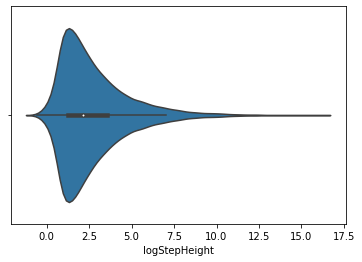

In [11]:
sns.violinplot(data=df, x='logStepHeight')
plt.show()

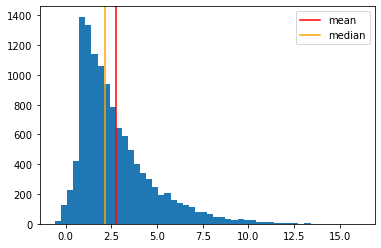

In [10]:
data_mean = np.mean(df['logStepHeight'].values)
data_med = np.median(df['logStepHeight'].values)
plt.hist(data=df, x='logStepHeight',bins=50)
plt.axvline(data_mean, color='red',label='mean')
plt.axvline(data_med, color='orange',label='median')
plt.legend()
plt.show()

### *This is the distribution I'm trying to predict*

## Add Null Seq Column

In [12]:
def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

df['shuffled_seq'] = df['seq'].apply(lambda x: shuffle_seq(x))
df[['seq','shuffled_seq']]

,seq,shuffled_seq
0,AAAAAAAACAACAGAGGACTAAACCGTGGCTTTTGCAATACAATTC...,CCATAACGGCATTCATTAATTACAACTACAAGTTGAAGTCACAGAA...
1,AAAAAAAAGCGGCCTATGGCGCACTGGCGGATGTGCTGGATAATGA...,GGATACGAACGCACGAATGTGTGGTCGAATAGACCGGGCGTCAATA...
2,AAAAAAAGCCCGTCCAGTGGCGGACGGGCAAACAAGGGTAACATAG...,AGAGAGGCCCCTTCGCAAGCTGCCGAAAAAAAGAGCGCGGAGATAA...
3,AAAAAAAGGTTGCATGAAAACGCGAGCGGAGTATAGTGCGCATCCA...,AACGAAATCAGAGACAATGCTCGCAGGAGGAAGCGACGCAAAGTAG...
4,AAAAAACAATTAAACGTAAACTTTGCGCAATTCAGACCGATAACCC...,CCACCAAGGCACACACAATCACCAGAATCATAAGGATAATTGTTTT...
...,...,...
11913,TTTTTTGCACAACCGCAGAACTTTTCCGCAGGGCATCAGTCTTAAT...,ATCTCAGTGTCGGATTCAGTGCTCCTAGAAAACGACGTTTCTCTAT...
11914,TTTTTTGCACACTTATGCAACGGAATACGCGCCGATATATCATTGT...,TATATGTTTAACAGTGCATATTAGCCTTCGTGGATCACCCATTACT...
11915,TTTTTTTACTCCCGTCAGCGCGTTACCCCAATTGTAGATAAAATTG...,GTAGCTTACAGCTTCAGCCCTTTCCGATTTTAATAAAAGTTTATAC...
11916,TTTTTTTAGCGATGATAAAAAATCTCACCGTCGTAGGCTTTAATGA...,TTGTCTTAATTGTAGAAGTTTTACGTACGCCAAATATATCTAGGTT...


## Train/test split

In [13]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
    sns.violinplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
    sns.boxplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True)
    plt.title(f"{title} distribution")
    plt.show()

In [14]:
# LOG
#full_train_df,test_df = tu.quick_split(XY_df)
full_train_df,test_df = tu.quick_split(df)
train_df, val_df = tu.quick_split(full_train_df)

print('full train:',full_train_df.shape)
print('test:',test_df.shape)
print('train:',train_df.shape)
print('val:',val_df.shape)

assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])

full train: (9534, 30)
test: (2384, 30)
train: (7627, 31)
val: (1907, 31)


In [15]:
full_train_df

,index,seq,Pos,Strand,detCount,Condition,detected,enriched,stepHeight,stepFactor,...,Automated,Manual,Putative sRNA,Putative asRNA,Comment,Sequence -50 nt upstream + TSS (51nt),Overlap with RegulonDB,in_wang,logStepHeight,shuffled_seq
0,0,AAAAAAAACAACAGAGGACTAAACCGTGGCTTTTGCAATACAATTC...,2481542,+,3,LB_2.0,1,1,3.48,>100,...,1,0,0,0,,AAAAAAAACAACAGAGGACTAAACCGTGGCTTTTGCAATACAATTC...,,True,1.799087,CCATAACGGCATTCATTAATTACAACTACAAGTTGAAGTCACAGAA...
1,1,AAAAAAAAGCGGCCTATGGCGCACTGGCGGATGTGCTGGATAATGA...,844523,-,3,LB_2.0,1,1,1.85,>100,...,1,0,0,0,,AAAAAAAAGCGGCCTATGGCGCACTGGCGGATGTGCTGGATAATGA...,,True,0.887525,GGATACGAACGCACGAATGTGTGGTCGAATAGACCGGGCGTCAATA...
2,2,AAAAAAAGCCCGTCCAGTGGCGGACGGGCAAACAAGGGTAACATAG...,836709,+,2,LB_2.0,1,1,5.40,>100,...,1,0,0,0,,AAAAAAAGCCCGTCCAGTGGCGGACGGGCAAACAAGGGTAACATAG...,,True,2.432959,AGAGAGGCCCCTTCGCAAGCTGCCGAAAAAAAGAGCGCGGAGATAA...
3,3,AAAAAAAGGTTGCATGAAAACGCGAGCGGAGTATAGTGCGCATCCA...,2945409,+,1,LB_2.0,1,1,1215.24,29.67,...,1,0,0,0,,AAAAAAAGGTTGCATGAAAACGCGAGCGGAGTATAGTGCGCATCCA...,,True,10.247026,AACGAAATCAGAGACAATGCTCGCAGGAGGAAGCGACGCAAAGTAG...
4,4,AAAAAACAATTAAACGTAAACTTTGCGCAATTCAGACCGATAACCC...,2001860,+,2,LB_2.0,1,1,248.22,3.87,...,1,0,0,0,,AAAAAACAATTAAACGTAAACTTTGCGCAATTCAGACCGATAACCC...,X,True,7.955476,CCACCAAGGCACACACAATCACCAGAATCATAAGGATAATTGTTTT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11912,11912,TTTTTTCCCCAAAATCGACTTACTTATTTCTGTCGGCGATAATATT...,2857945,+,3,LB_2.0,1,1,6.90,56,...,1,0,0,0,,TTTTTTCCCCAAAATCGACTTACTTATTTCTGTCGGCGATAATATT...,,True,2.786596,CTTTTAATCGAAACAGGTAATATTATCTCTTCCCTGTGATGCTTCC...
11913,11913,TTTTTTGCACAACCGCAGAACTTTTCCGCAGGGCATCAGTCTTAAT...,887280,-,3,LB_2.0,1,1,827.59,>100,...,1,0,0,1,,TTTTTTGCACAACCGCAGAACTTTTCCGCAGGGCATCAGTCTTAAT...,X,True,9.692772,ATCTCAGTGTCGGATTCAGTGCTCCTAGAAAACGACGTTTCTCTAT...
11914,11914,TTTTTTGCACACTTATGCAACGGAATACGCGCCGATATATCATTGT...,1905782,+,2,LB_2.0,1,1,2.79,>100,...,1,0,0,0,,TTTTTTGCACACTTATGCAACGGAATACGCGCCGATATATCATTGT...,,True,1.480265,TATATGTTTAACAGTGCATATTAGCCTTCGTGGATCACCCATTACT...
11916,11916,TTTTTTTAGCGATGATAAAAAATCTCACCGTCGTAGGCTTTAATGA...,2185275,-,1,LB_2.0,1,1,1.63,7.5,...,1,0,0,1,,TTTTTTTAGCGATGATAAAAAATCTCACCGTCGTAGGCTTTAATGA...,,True,0.704872,TTGTCTTAATTGTAGAAGTTTTACGTACGCCAAATATATCTAGGTT...


In [16]:
train_df

,level_0,index,seq,Pos,Strand,detCount,Condition,detected,enriched,stepHeight,...,Automated,Manual,Putative sRNA,Putative asRNA,Comment,Sequence -50 nt upstream + TSS (51nt),Overlap with RegulonDB,in_wang,logStepHeight,shuffled_seq
0,0,0,AAAAAAAACAACAGAGGACTAAACCGTGGCTTTTGCAATACAATTC...,2481542,+,3,LB_2.0,1,1,3.48,...,1,0,0,0,,AAAAAAAACAACAGAGGACTAAACCGTGGCTTTTGCAATACAATTC...,,True,1.799087,CCATAACGGCATTCATTAATTACAACTACAAGTTGAAGTCACAGAA...
2,2,2,AAAAAAAGCCCGTCCAGTGGCGGACGGGCAAACAAGGGTAACATAG...,836709,+,2,LB_2.0,1,1,5.40,...,1,0,0,0,,AAAAAAAGCCCGTCCAGTGGCGGACGGGCAAACAAGGGTAACATAG...,,True,2.432959,AGAGAGGCCCCTTCGCAAGCTGCCGAAAAAAAGAGCGCGGAGATAA...
3,3,3,AAAAAAAGGTTGCATGAAAACGCGAGCGGAGTATAGTGCGCATCCA...,2945409,+,1,LB_2.0,1,1,1215.24,...,1,0,0,0,,AAAAAAAGGTTGCATGAAAACGCGAGCGGAGTATAGTGCGCATCCA...,,True,10.247026,AACGAAATCAGAGACAATGCTCGCAGGAGGAAGCGACGCAAAGTAG...
4,4,4,AAAAAACAATTAAACGTAAACTTTGCGCAATTCAGACCGATAACCC...,2001860,+,2,LB_2.0,1,1,248.22,...,1,0,0,0,,AAAAAACAATTAAACGTAAACTTTGCGCAATTCAGACCGATAACCC...,X,True,7.955476,CCACCAAGGCACACACAATCACCAGAATCATAAGGATAATTGTTTT...
5,7,7,AAAAAACTAACAGTTGTCAGCCTGTCCCGCTTATAAGATCATACGC...,705286,+,3,LB_2.0,1,1,42.99,...,1,0,0,0,,AAAAAACTAACAGTTGTCAGCCTGTCCCGCTTATAAGATCATACGC...,X,True,5.425929,CTGACTGAGCGATTACAACCCACCTTATAATGGCAGTCAATCTCTA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9526,11909,11909,TTTTTTATCTGCTTTTGTCATTAACACGGCACACAGGCGTAATATC...,1934614,+,2,LB_2.0,1,1,19.14,...,1,0,0,0,,TTTTTTATCTGCTTTTGTCATTAACACGGCACACAGGCGTAATATC...,X,True,4.258519,AAGTAATAATCCGGTCCTGAAGGTCTTCCGCTGTATCTTCAATTTA...
9528,11911,11911,TTTTTTCAGCACTAGATTTTCTTCCTCTCCAGCAGTGGTAGAATAG...,1906591,-,3,LB_2.0,1,1,134.90,...,1,0,0,0,,TTTTTTCAGCACTAGATTTTCTTCCTCTCCAGCAGTGGTAGAATAG...,,True,7.075747,TAGCCATACTCAGATCAGTCACGATTCGTCTATTTGCCTGTTTGCA...
9529,11912,11912,TTTTTTCCCCAAAATCGACTTACTTATTTCTGTCGGCGATAATATT...,2857945,+,3,LB_2.0,1,1,6.90,...,1,0,0,0,,TTTTTTCCCCAAAATCGACTTACTTATTTCTGTCGGCGATAATATT...,,True,2.786596,CTTTTAATCGAAACAGGTAATATTATCTCTTCCCTGTGATGCTTCC...
9530,11913,11913,TTTTTTGCACAACCGCAGAACTTTTCCGCAGGGCATCAGTCTTAAT...,887280,-,3,LB_2.0,1,1,827.59,...,1,0,0,1,,TTTTTTGCACAACCGCAGAACTTTTCCGCAGGGCATCAGTCTTAAT...,X,True,9.692772,ATCTCAGTGTCGGATTCAGTGCTCCTAGAAAACGACGTTTCTCTAT...


In [17]:
split_dfs = {
    'full_train':full_train_df,
    'train':train_df,
    'val':val_df,
    'test':test_df,   
}

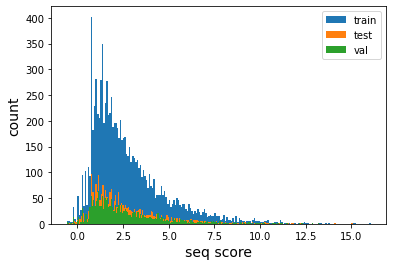

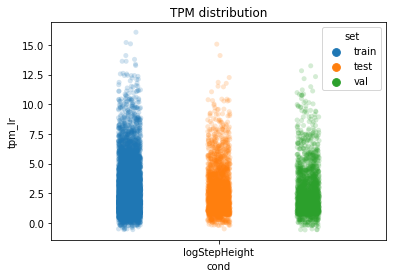

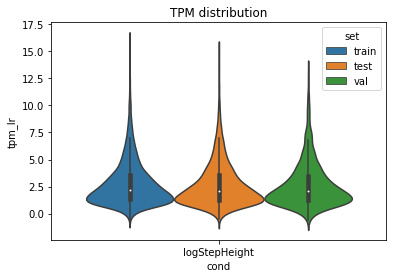

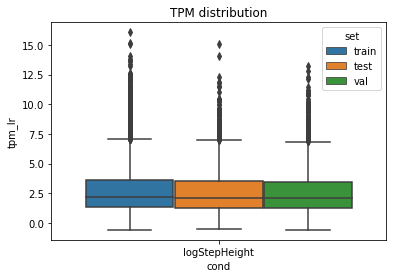

In [18]:
plot_train_test_hist(full_train_df, test_df,score_col='logStepHeight',bins=200,val_df=val_df)
view_train_test_dist(train_df, test_df,["logStepHeight"],"TPM",id_col='index',val_df=val_df)

# split the genes, show dist of logTPM of HighCu column
# plot_train_test_hist(train_df, test_df, val_df=val_df,score_col='log_overall_mean_tpm',bins=200)
# view_train_test_dist(train_df, test_df,["log_overall_mean_tpm"],"TPM",val_df=val_df)

## Load 5G seqs into data loaders

In [19]:
dataset_types = [
    DatasetSpec('ohe'),
#     DatasetSpec('kmer',k=3),
#     DatasetSpec('kmer',k=6),
]

# _RUNNING normal seqs

In [20]:
seq_col_name = 'seq'
target_col_name = 'logStepHeight'

# Dfs for the full train/test split
final_dls = tu.build_dataloaders_single(
    full_train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name
)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [21]:
for xb,yb, in ohe_val_dl:
    print(xb.shape)
    print(yb.shape)
    print()

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([128, 50, 4])
torch.Size([128, 1])

torch.Size([115, 50, 4])
torch.Size([115, 1])



In [22]:
ohe_val_dl.batch_size

128

In [23]:
y1,y2 = [1,2,3],[4,5,6]
r = r2_score(y1,y2)
p = pearsonr(y1,y2)
s = spearmanr(y1,y2)
print(r)
print(p[0])
print(s.correlation)

-12.5
0.9999999999999998
1.0


## run model 

In [24]:
def collect_model_stats(model_name,seq_len,encoding,
                        train_dl,val_dl,
                        lr=0.001,ep=1000,pat=100,
                        opt=None,model=None,load_best=False):
    
    if not model:
        model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            1, # num tasks
        )
    model.to(DEVICE)

    loss_func = torch.nn.MSELoss() 
    if opt:
        opt = opt(model.parameters(), lr=lr)

    # pass in
    #train_dl,val_dl = dls[encoding] 
    
    train_losses, \
    val_losses, \
    epoch_stop, \
    best_val_score = tu.run_model(
        train_dl,
        val_dl, 
        model, 
        loss_func, 
        DEVICE,
        lr=lr, 
        epochs=ep, 
        opt=opt,
        patience=pat,
        load_best=load_best # leave false to see overfitting in parity plots
    )

    # to plot loss
    data_label = [((train_losses,val_losses),model_name,epoch_stop,best_val_score)]
    tu.quick_loss_plot(data_label)
    
    return {
        'model_name':model_name,
        'model':model,
        'train_losses':train_losses,
        'val_losses':val_losses,
        'epoch_stop':epoch_stop,
        'best_val_score':best_val_score,
        'data_label':data_label
    }

In [25]:
def parity_pred_by_split(model_name,
                         device,
                         split_dfs,
                         locus_col='locus_tag',
                         seq_col='seq',
                         target_col="score",
                         splits=['train','val'],
                         alpha=0.2
                        ):
    '''
    Given a trained model, get the model's predictions on each split
    of the data and create parity plots of the y predictions vs actual ys
    '''
    # init subplots
    fig, axs = plt.subplots(1,len(splits), sharex=True, sharey=True,figsize=(10,4))
    pred_dfs = {}
    
    def parity_plot(model_title,ytrue,ypred,rigid=True):
        axs[i].scatter(ytrue, ypred, alpha=alpha)

        r2 = r2_score(ytrue,ypred)
        pr = pearsonr(ytrue,ypred)[0]
        sp = spearmanr(ytrue,ypred).correlation

        # y=x line
        xpoints = ypoints = plt.xlim()
        if rigid:
            axs[i].set_ylim(min(xpoints),max(xpoints)) 
        axs[i].plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)
        axs[i].set_title(f"{model_title} (r2:{r2:.2f}|p:{pr:.2f}|sp:{sp:.2f})",fontsize=14)
        axs[i].set_xlabel("Actual Score",fontsize=14)
        axs[i].set_ylabel("Predicted Score",fontsize=14)
    
    for i,split in enumerate(splits):
        print(f"{split} split")
        df = split_dfs[split]
        loci = df[locus_col].values
        seqs = list(df[seq_col].values)        
        ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(device)
        labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
    #dfs = {} # key: model name, value: parity_df
    
        # initialize prediction df with just locus col
        pred_df = df[[locus_col]]
        pred_df['truth'] = df[target_col]
        print(f"Running {model_name}")
        
        model = model_res[model_name]['model']
        # ask model to predict on seqs
        preds = model(ohe_seqs.float()).tolist()
        # preds is a tensor converted to a list, 
        # single elements returned as a list, hence x[0]
        pred_df['pred'] = [x[0] for x in preds]
        
        # do I want the result dfs? revise if so
        #dfs[model_name] = pred_df
        
        # plot stuff
        ytrue = pred_df['truth'].values
        ypred = pred_df['pred'].values
        
        #plt.subplot(len(splits),i+1,1)
        model_title = split
        parity_plot(model_title,ytrue,ypred,rigid=True)
        
        # save predictions
        pred_dfs[split] = pred_df
    
    
    plt.suptitle(model_name,fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return pred_dfs

In [26]:
model_res = {}
seq_len = len(train_df[seq_col_name].values[0])

E:442 | train loss:2.825 | val loss: 4.034:   9%|▉         | 443/5000 [01:52<18:38,  4.07it/s]

EarlyStopping counter: 125 out of 500


E:567 | train loss:2.313 | val loss: 4.108:  11%|█▏        | 568/5000 [02:23<18:16,  4.04it/s]

EarlyStopping counter: 250 out of 500


E:692 | train loss:1.943 | val loss: 4.170:  14%|█▍        | 693/5000 [02:53<17:38,  4.07it/s]

EarlyStopping counter: 375 out of 500


E:817 | train loss:1.711 | val loss: 4.194:  16%|█▋        | 817/5000 [03:24<17:28,  3.99it/s]

EarlyStopping counter: 500 out of 500
Early stopping


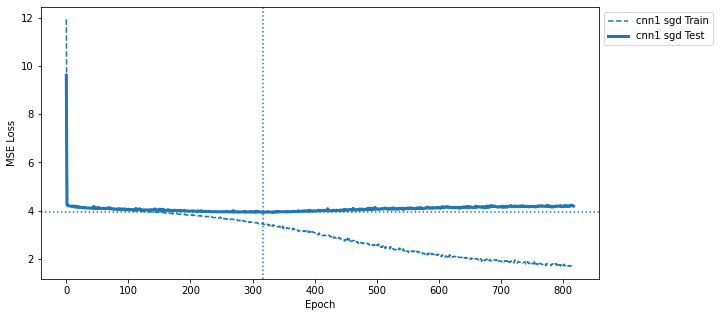

In [27]:
cnn1_name = 'cnn1 sgd'
model_res[cnn1_name] = collect_model_stats(
    cnn1_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn1 sgd
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn1 sgd
test split
Running cnn1 sgd


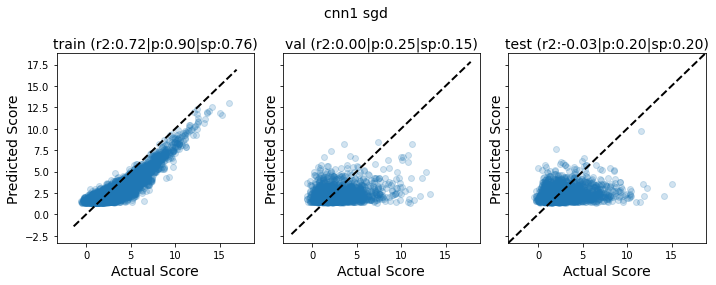

In [28]:
pred_dfs = parity_pred_by_split(cnn1_name,
                     DEVICE,
                     split_dfs,
                     locus_col='index',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

In [ ]:
#mmmmkkkkkk

E:88 | train loss:2.434 | val loss: 4.154:   4%|▍         | 89/2000 [00:22<08:03,  3.96it/s]

EarlyStopping counter: 50 out of 200


E:138 | train loss:1.843 | val loss: 4.329:   7%|▋         | 139/2000 [00:35<07:51,  3.95it/s]

EarlyStopping counter: 100 out of 200


E:188 | train loss:1.544 | val loss: 4.519:   9%|▉         | 189/2000 [00:48<07:40,  3.93it/s]

EarlyStopping counter: 150 out of 200


E:238 | train loss:1.419 | val loss: 4.529:  12%|█▏        | 238/2000 [01:00<07:29,  3.92it/s]

EarlyStopping counter: 200 out of 200
Early stopping


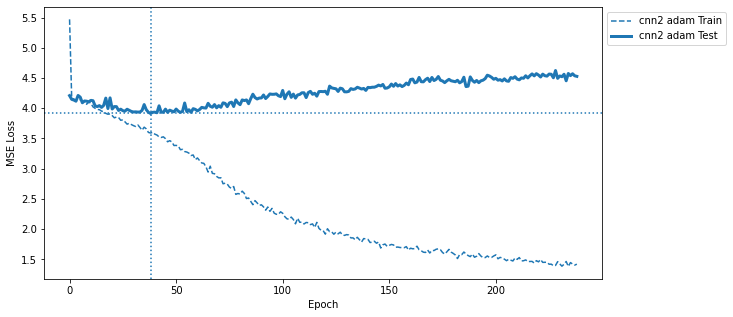

In [29]:
cnn2_name = 'cnn2 adam'
model_res[cnn2_name] = collect_model_stats(
    cnn2_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn2 adam
val split
Running cnn2 adam


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split
Running cnn2 adam


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


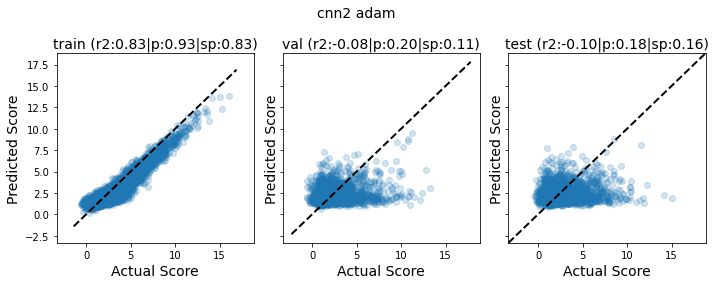

In [30]:
pred_dfs = parity_pred_by_split(cnn2_name,
                                DEVICE,
                                split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

In [ ]:
# what about this?

E:267 | train loss:3.456 | val loss: 3.970:  13%|█▎        | 268/2000 [01:08<07:22,  3.91it/s]

EarlyStopping counter: 50 out of 200


E:317 | train loss:3.239 | val loss: 4.027:  16%|█▌        | 318/2000 [01:21<07:11,  3.90it/s]

EarlyStopping counter: 100 out of 200


E:367 | train loss:2.972 | val loss: 4.094:  18%|█▊        | 368/2000 [01:34<06:58,  3.90it/s]

EarlyStopping counter: 150 out of 200


E:417 | train loss:2.797 | val loss: 4.163:  21%|██        | 417/2000 [01:47<06:46,  3.89it/s]

EarlyStopping counter: 200 out of 200
Early stopping


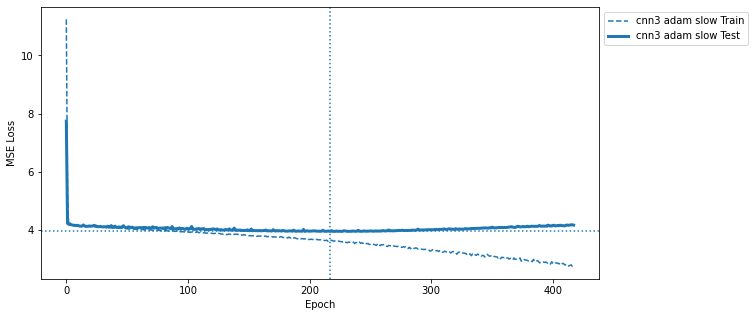

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn3 adam slow
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn3 adam slow
test split
Running cnn3 adam slow


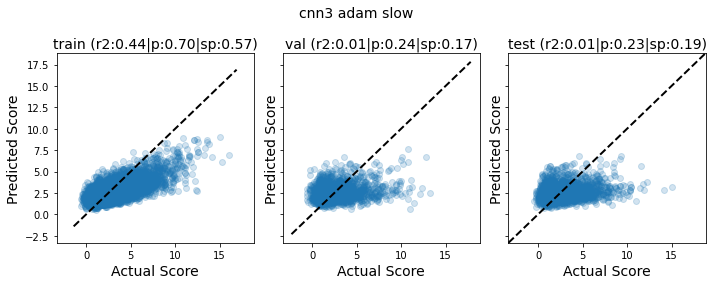

In [32]:
cnn3_name = 'cnn3 adam slow'
model_res[cnn3_name] = collect_model_stats(
    cnn3_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

cnn3_pred_dfs = parity_pred_by_split(cnn3_name,
                     DEVICE,
                     split_dfs,
                     locus_col='index',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

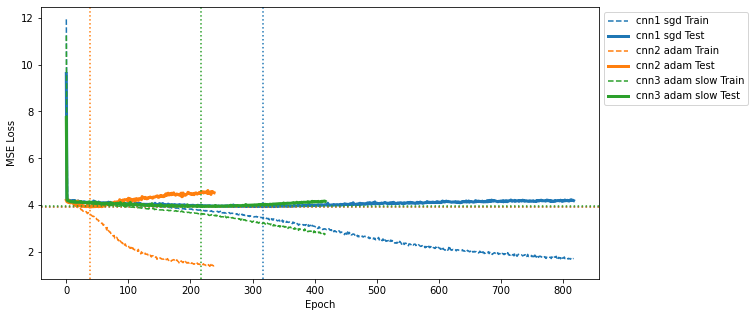

In [33]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [ ]:
pred_dfs = {}

E:367 | train loss:3.309 | val loss: 3.972:  18%|█▊        | 368/2000 [03:31<15:35,  1.74it/s]

EarlyStopping counter: 50 out of 200


E:417 | train loss:2.924 | val loss: 4.023:  21%|██        | 418/2000 [04:00<15:11,  1.74it/s]

EarlyStopping counter: 100 out of 200


E:467 | train loss:2.460 | val loss: 4.335:  23%|██▎       | 468/2000 [04:29<14:42,  1.74it/s]

EarlyStopping counter: 150 out of 200


E:517 | train loss:1.943 | val loss: 4.396:  26%|██▌       | 517/2000 [04:58<14:14,  1.73it/s]

EarlyStopping counter: 200 out of 200
Early stopping


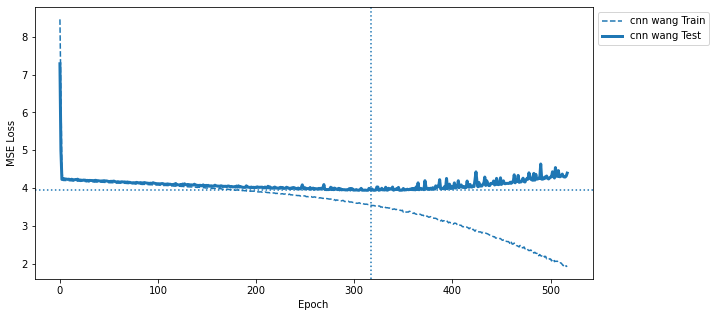

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn wang
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn wang
test split
Running cnn wang


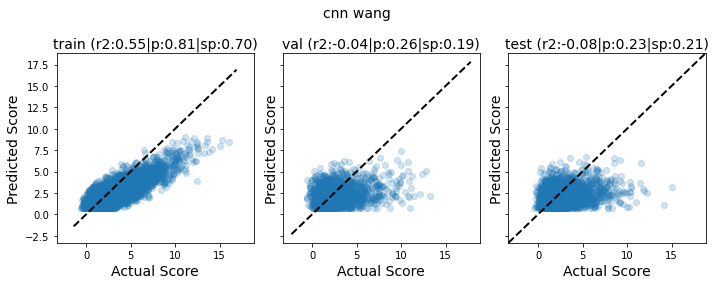

In [42]:
cnn_wang = 'cnn wang'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=100,
    num_filters2=200,
    kernel_size1=6,
    kernel_size2=5,
    conv_pool_size1=2,
    fc_node_num1=1024,
    fc_node_num2=1,
    dropout1=0
)

model_res[cnn_wang] = collect_model_stats(
    cnn_wang,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0005,
    ep=2000,
    pat=200,
    opt=torch.optim.SGD,
    model=model
)

pred_dfs[cnn_wang] = parity_pred_by_split(cnn_wang,
                     DEVICE,
                     split_dfs,
                     locus_col='index',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

In [43]:
model_res[cnn_wang]['model']

DNA_2CNN_2FC_Multi(
  (conv_net): Sequential(
    (0): Conv2d(1, 100, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Conv2d(100, 200, kernel_size=(1, 5), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=3600, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=1, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1, out_features=1, bias=True)
  )
)

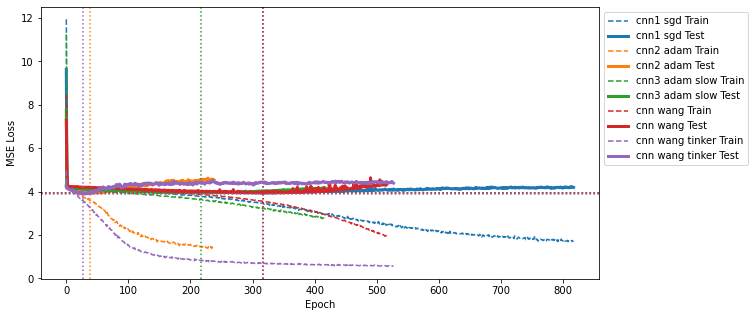

In [46]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

E:152 | train loss:1.039 | val loss: 4.329:   3%|▎         | 153/5000 [00:52<27:27,  2.94it/s]

EarlyStopping counter: 125 out of 500


E:277 | train loss:0.745 | val loss: 4.415:   6%|▌         | 278/5000 [01:34<26:44,  2.94it/s]

EarlyStopping counter: 250 out of 500


E:402 | train loss:0.607 | val loss: 4.449:   8%|▊         | 403/5000 [02:17<26:07,  2.93it/s]

EarlyStopping counter: 375 out of 500


E:527 | train loss:0.571 | val loss: 4.391:  11%|█         | 527/5000 [02:59<25:24,  2.93it/s]

EarlyStopping counter: 500 out of 500
Early stopping


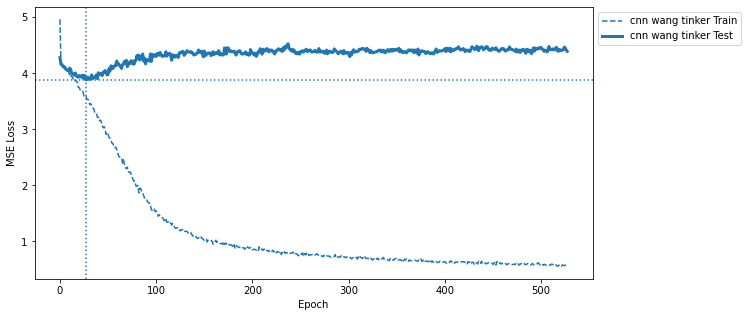

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn wang tinker
val split
Running cnn wang tinker
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn wang tinker


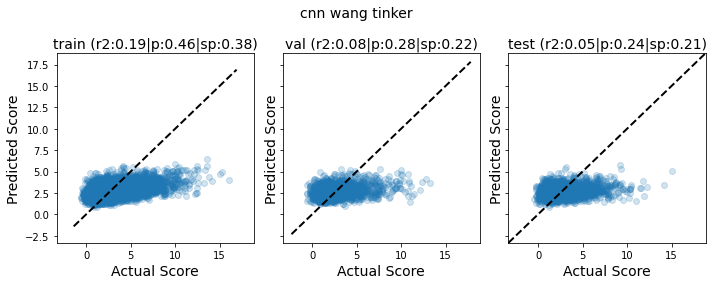

In [45]:
cnn_wang_tinker = 'cnn wang tinker'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=64,
    num_filters2=32,
    kernel_size1=6,
    kernel_size2=5,
    conv_pool_size1=2,
    fc_node_num1=100,
    fc_node_num2=10,
    dropout1=0.2
)

model_res[cnn_wang_tinker] = collect_model_stats(
    cnn_wang_tinker,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0005,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
    load_best=True
)

pred_dfs[cnn_wang_tinker] = parity_pred_by_split(cnn_wang_tinker,
                     DEVICE,
                     split_dfs,
                     locus_col='index',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

# try again with shuffled seqs

In [47]:
seq_col_name = 'shuffled_seq'
target_col_name = 'logStepHeight'

# # Dfs for the full train/test split
# final_dls_shuff = tu.build_dataloaders_single(
#     full_train_df, 
#     test_df, 
#     dataset_types,
#     seq_col=seq_col_name,
#     target_col=target_col_name
# )

# Dfs from further spliting train into train and val
dls_shuff = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
shuff_ohe_train_dl,shuff_ohe_val_dl = dls_shuff['ohe']

E:185 | train loss:4.080 | val loss: 4.153:   9%|▉         | 186/2000 [00:45<07:26,  4.07it/s]

EarlyStopping counter: 50 out of 200


E:235 | train loss:4.070 | val loss: 4.172:  12%|█▏        | 236/2000 [00:58<07:15,  4.05it/s]

EarlyStopping counter: 100 out of 200


E:285 | train loss:4.012 | val loss: 4.177:  14%|█▍        | 286/2000 [01:10<07:00,  4.07it/s]

EarlyStopping counter: 150 out of 200


E:335 | train loss:3.960 | val loss: 4.199:  17%|█▋        | 335/2000 [01:22<06:51,  4.05it/s]

EarlyStopping counter: 200 out of 200
Early stopping


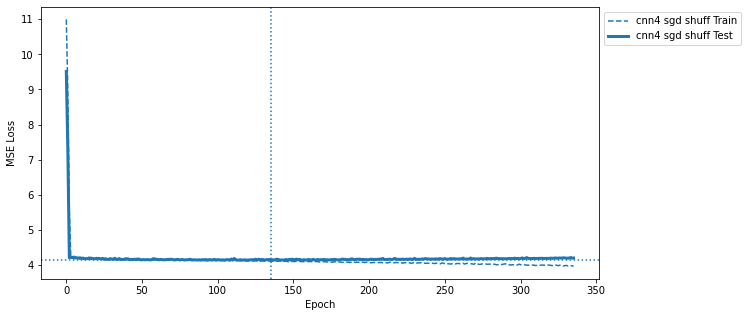

In [49]:
cnn4_name = 'cnn4 sgd shuff'
model_res[cnn4_name] = collect_model_stats(
    cnn4_name,
    seq_len,
    'ohe',
    shuff_ohe_train_dl,
    shuff_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn4 sgd shuff
val split
Running cnn4 sgd shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

test split
Running cnn4 sgd shuff


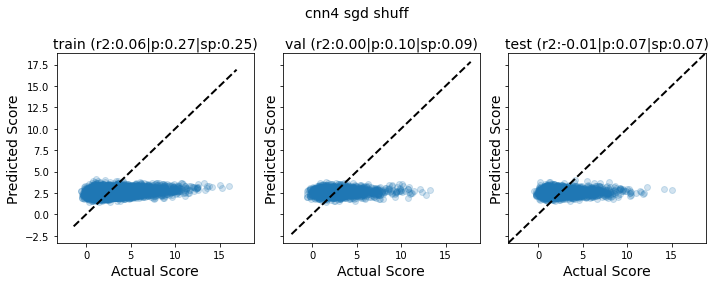

In [50]:
pred_dfs[cnn4_name] = parity_pred_by_split(cnn4_name,
                     DEVICE,
                     split_dfs,
                     locus_col='index',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

E:61 | train loss:3.501 | val loss: 4.398:   3%|▎         | 62/2000 [00:16<08:22,  3.86it/s]

EarlyStopping counter: 50 out of 200


E:111 | train loss:2.655 | val loss: 4.770:   6%|▌         | 112/2000 [00:29<08:10,  3.85it/s]

EarlyStopping counter: 100 out of 200


E:161 | train loss:2.236 | val loss: 4.917:   8%|▊         | 162/2000 [00:42<07:58,  3.84it/s]

EarlyStopping counter: 150 out of 200


E:211 | train loss:2.012 | val loss: 5.094:  11%|█         | 211/2000 [00:55<07:46,  3.83it/s]

EarlyStopping counter: 200 out of 200
Early stopping


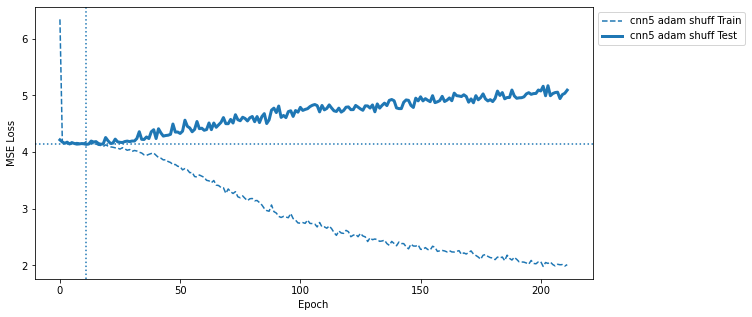

In [51]:
cnn5_name = 'cnn5 adam shuff'
model_res[cnn5_name] = collect_model_stats(
    cnn5_name,
    seq_len,
    'ohe',
    shuff_ohe_train_dl,
    shuff_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn5 adam shuff
val split
Running cnn5 adam shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split
Running cnn5 adam shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


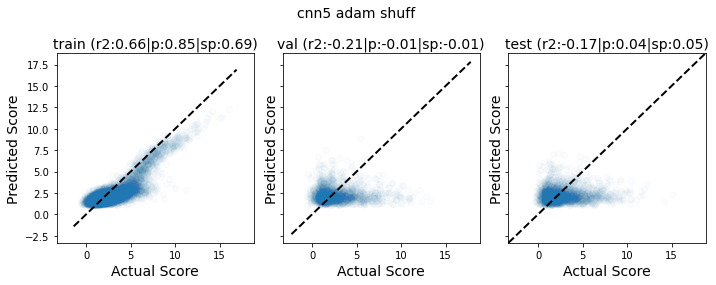

In [55]:
pred_dfs[cnn5_name] = parity_pred_by_split(cnn5_name,
                                DEVICE,
                                split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test'],
                                           alpha=0.02
                    )

E:123 | train loss:4.067 | val loss: 4.187:   6%|▌         | 124/2000 [00:32<08:09,  3.83it/s]

EarlyStopping counter: 50 out of 200


E:173 | train loss:4.026 | val loss: 4.216:   9%|▊         | 174/2000 [00:45<07:57,  3.83it/s]

EarlyStopping counter: 100 out of 200


E:223 | train loss:3.971 | val loss: 4.227:  11%|█         | 224/2000 [00:58<07:42,  3.84it/s]

EarlyStopping counter: 150 out of 200


E:273 | train loss:3.914 | val loss: 4.269:  14%|█▎        | 273/2000 [01:11<07:30,  3.83it/s]

EarlyStopping counter: 200 out of 200
Early stopping


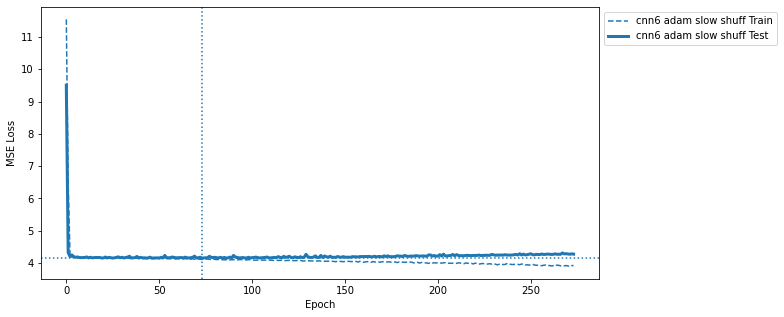

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn6 adam slow shuff
val split
Running cnn6 adam slow shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

test split
Running cnn6 adam slow shuff


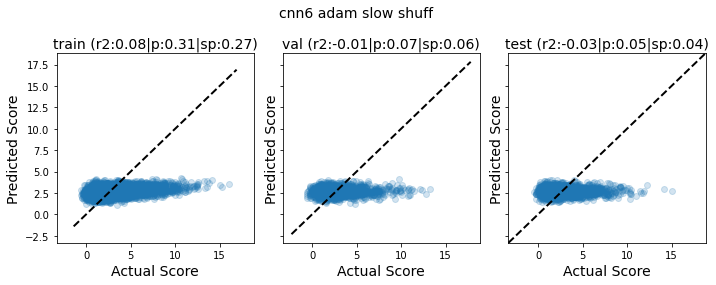

In [53]:
cnn6_name = 'cnn6 adam slow shuff'
model_res[cnn6_name] = collect_model_stats(
    cnn6_name,
    seq_len,
    'ohe',
    shuff_ohe_train_dl,
    shuff_ohe_val_dl,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

pred_dfs = parity_pred_by_split(cnn6_name,
                     DEVICE,
                     split_dfs,
                     locus_col='index',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

E:105 | train loss:4.192 | val loss: 4.222:   5%|▌         | 106/2000 [01:02<17:48,  1.77it/s]

EarlyStopping counter: 50 out of 200


E:155 | train loss:4.192 | val loss: 4.223:   8%|▊         | 156/2000 [01:30<17:17,  1.78it/s]

EarlyStopping counter: 100 out of 200


E:205 | train loss:4.192 | val loss: 4.223:  10%|█         | 206/2000 [01:58<16:49,  1.78it/s]

EarlyStopping counter: 150 out of 200


E:255 | train loss:4.192 | val loss: 4.223:  13%|█▎        | 255/2000 [02:26<16:44,  1.74it/s]

EarlyStopping counter: 200 out of 200
Early stopping


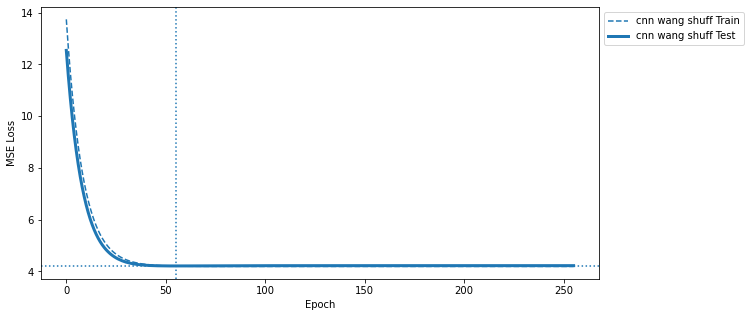

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/u

Running cnn wang shuff
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/u

Running cnn wang shuff
test split
Running cnn wang shuff


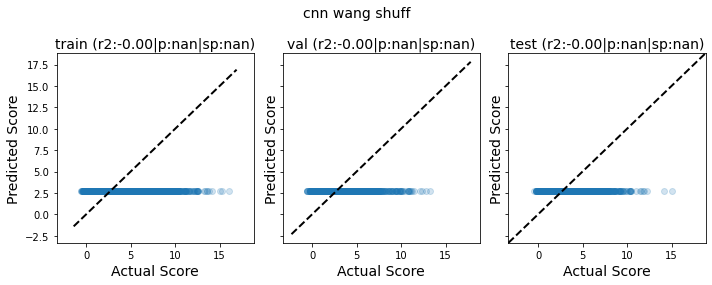

In [54]:
cnn_wang_shuff = 'cnn wang shuff'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=100,
    num_filters2=200,
    kernel_size1=6,
    kernel_size2=5,
    conv_pool_size1=2,
    fc_node_num1=1024,
    fc_node_num2=1,
    dropout1=0
)

model_res[cnn_wang_shuff] = collect_model_stats(
    cnn_wang_shuff,
    seq_len,
    'ohe',
    shuff_ohe_train_dl,
    shuff_ohe_val_dl,
    lr=0.0005,
    ep=2000,
    pat=200,
    opt=torch.optim.SGD,
    model=model
)

pred_dfs[cnn_wang_shuff] = parity_pred_by_split(cnn_wang_shuff,
                     DEVICE,
                     split_dfs,
                     locus_col='index',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

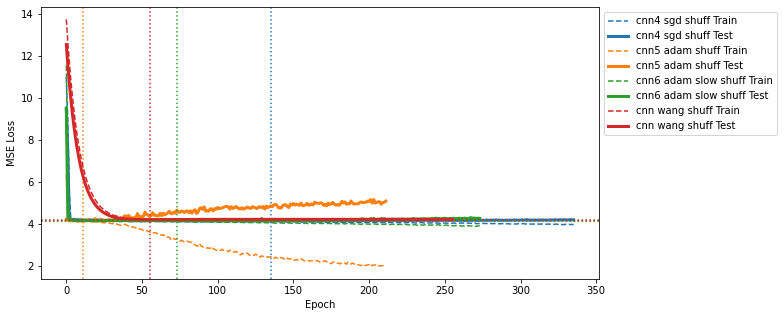

In [56]:
shuffled_models = [cnn4_name, cnn5_name, cnn6_name, cnn_wang_shuff]
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in shuffled_models])

In [ ]:
# how does normal vs shuff look?

# Now try with top 5% of samples with most reads as test set

In [21]:
def top_n_split(df, n, sort_col):
    '''
    Given a value n, take the top n% of reads and use those as the test split.
    '''
    sorted_df = df.sort_values(sort_col,ascending=False)
    
    total_samples = df.shape[0]
    num_test_samples = int(n*total_samples)
    test_df = sorted_df.head(num_test_samples)
    train_df = sorted_df.tail(total_samples - num_test_samples)
    
    return train_df, test_df

In [22]:
full_train_df,test_df = top_n_split(df, 0.05, 't0')
train_df, val_df = tu.quick_split(full_train_df)

print('full train:',full_train_df.shape)
print('test:',test_df.shape)
print('train:',train_df.shape)
print('val:',val_df.shape)

assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])

split_dfs = {
    'full_train':full_train_df,
    'train':train_df,
    'val':val_df,
    'test':test_df,   
}

full train: (464881, 10)
test: (24467, 10)
train: (371904, 11)
val: (92977, 11)


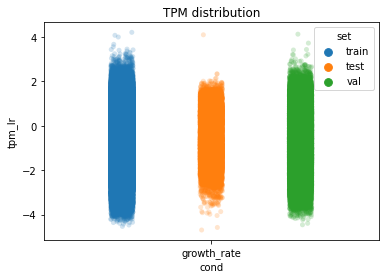

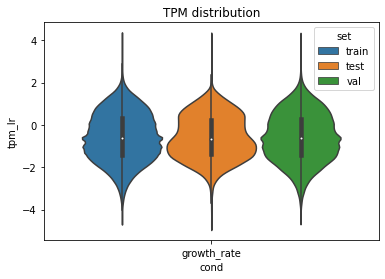

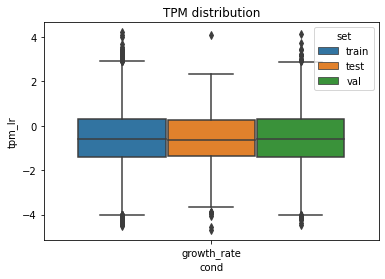

In [104]:
view_train_test_dist(train_df, test_df,["growth_rate"],"TPM",id_col='index',val_df=val_df)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


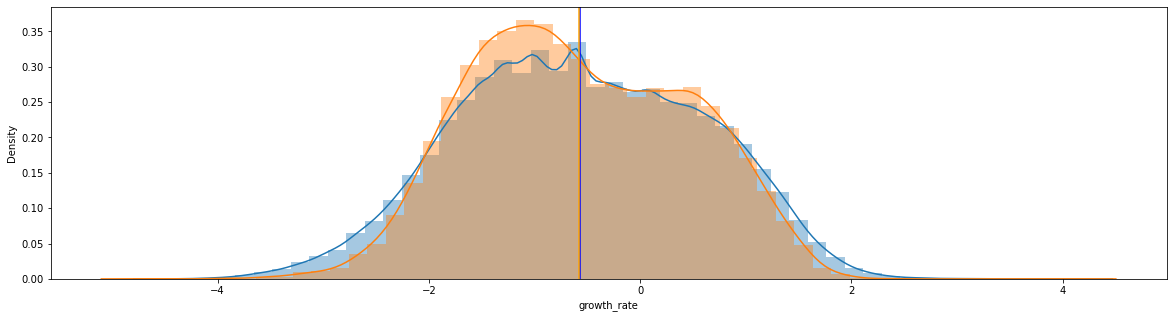

In [119]:
fig = plt.figure(figsize=(20,5))
sns.distplot(train_df['growth_rate'])
sns.distplot(test_df['growth_rate'])
plt.axvline(np.mean(train_df['growth_rate'].values),color='blue')
plt.axvline(np.mean(test_df['growth_rate'].values),color='orange')
#sns.distplot(val_df['growth_rate'])

In [23]:
seq_col_name = 'UTR'
target_col_name = 'growth_rate'

# Dfs for the full train/test split
final_dls = tu.build_dataloaders_single(
    full_train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name
)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [ ]:
cnn7_name = 'cnn7 sgd top5'
model_res[cnn7_name] = collect_model_stats(
    cnn7_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
)

pred_dfs = parity_pred_by_split(cnn7_name,
                                DEVICE,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

E:891 | train loss:0.712 | val loss: 0.704:  18%|█▊        | 892/5000 [2:56:30<13:33:42, 11.88s/it]

EarlyStopping counter: 125 out of 500


E:1185 | train loss:0.709 | val loss: 0.704:  24%|██▎       | 1186/5000 [3:54:43<12:34:42, 11.87s/it]

EarlyStopping counter: 125 out of 500


E:1409 | train loss:0.706 | val loss: 0.703:  28%|██▊       | 1409/5000 [4:39:05<11:50:26, 11.87s/it]

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn7 sgd top5


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn7 sgd top5


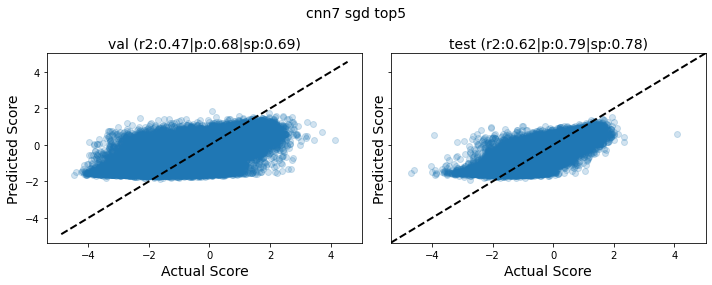

In [42]:
pred_dfs = parity_pred_by_split(cnn7_name,
                                DEVICE,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )

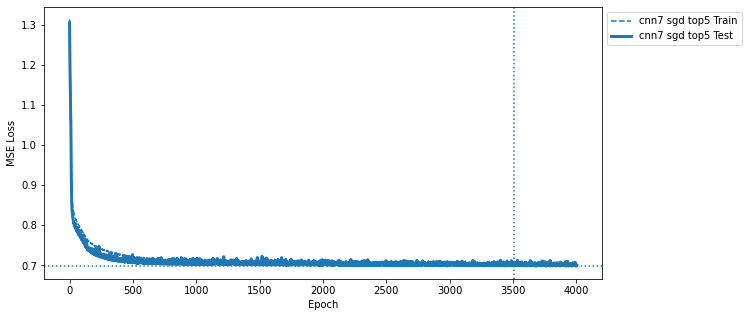

In [43]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

E:165 | train loss:0.717 | val loss: 0.711:   8%|▊         | 166/2000 [34:00<6:16:03, 12.30s/it]

EarlyStopping counter: 50 out of 200


E:215 | train loss:0.715 | val loss: 0.708:  11%|█         | 216/2000 [44:15<6:05:31, 12.29s/it]

EarlyStopping counter: 100 out of 200


E:265 | train loss:0.713 | val loss: 0.717:  13%|█▎        | 266/2000 [54:30<5:54:58, 12.28s/it]

EarlyStopping counter: 150 out of 200


E:315 | train loss:0.714 | val loss: 0.717:  16%|█▌        | 315/2000 [1:04:44<5:46:20, 12.33s/it]

EarlyStopping counter: 200 out of 200
Early stopping


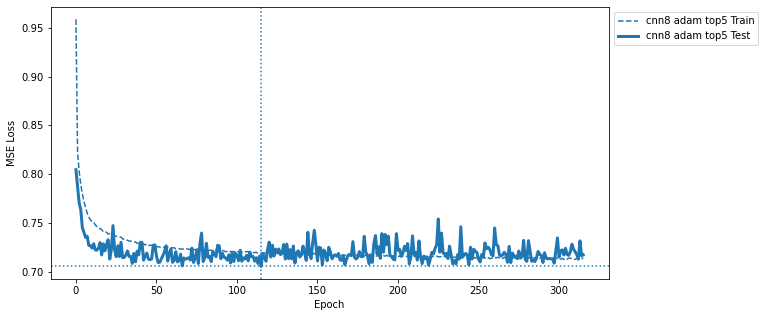

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5


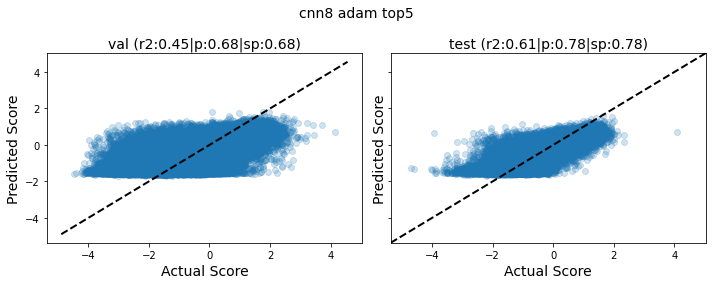

In [44]:
cnn8_name = 'cnn8 adam top5'
model_res[cnn8_name] = collect_model_stats(
    cnn8_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

pred_dfs = parity_pred_by_split(cnn8_name,
                                DEVICE,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5


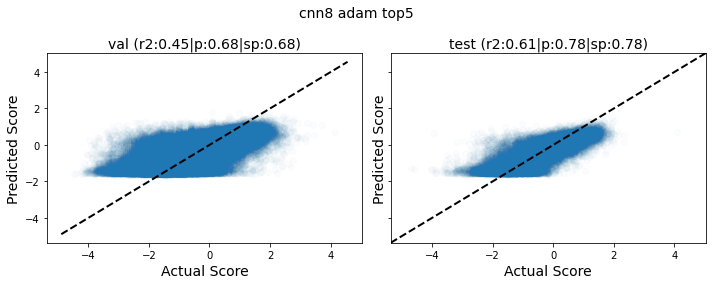

In [49]:
pred_dfs = parity_pred_by_split(cnn8_name,
                                DEVICE,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )

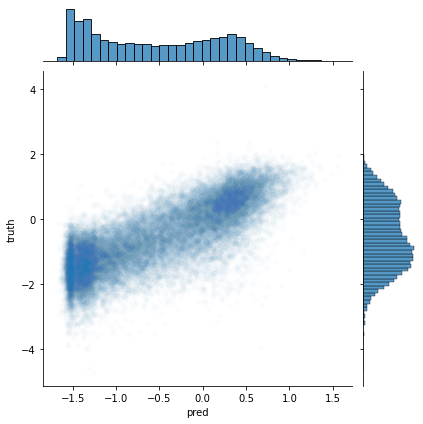

In [60]:
sns.jointplot(data = pred_dfs['test'], x='pred',y='truth',alpha=0.02)


(-4.0, 4.0)

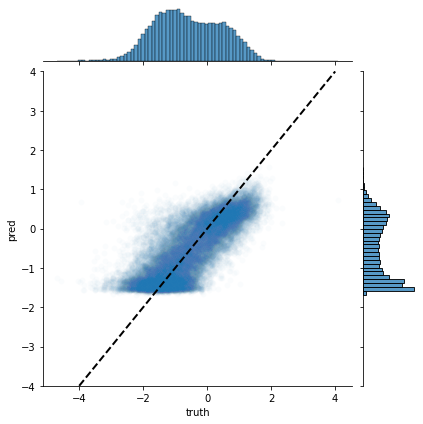

In [88]:
#fig = plt.figure(figsize=(10,10))
plot = sns.jointplot(data = pred_dfs['test'], x='truth',y='pred',alpha=0.02)
#plt.scatter(pred_dfs['test']['truth'],pred_dfs['test']['pred'])
xpoints = ypoints = (-4,4)
plot.ax_joint.plot([-4,4],[-4,4], linestyle='--', color='k', lw=2,)# scalex=False, scaley=False)
plt.ylim(min(xpoints),max(xpoints)) 


# Start reducing the dataset size

In [91]:
df

,UTR,growth_rate,t0,t1,t0_ps,t1_ps,t0_norm,t1_norm,enrich_score,shuffled_seq
0,AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...,-1.237065,14,3,15,4,6.500161e-07,1.886572e-07,-1.237065,TCAACAAATTTAAAACGTTACGTAGCAATAATAAGAAAAGTAATAA...
1,AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...,1.288663,14,49,15,50,6.500161e-07,2.358216e-06,1.288663,AAGGGTAAACTAACATACGGTAGGAACAAGTACAACGGGACTTACA...
2,AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...,-0.608457,13,6,14,7,6.066817e-07,3.301502e-07,-0.608457,TGAATGATAGAAAACGCAATTATATACGTTTCAATCCACCAAACAA...
3,AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...,-1.093964,12,3,13,4,5.633473e-07,1.886572e-07,-1.093964,ACTTGAGTGAGAACAAACGAATATCTAACTTAAGTTATTCGTTAAG...
4,AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...,-0.048841,7,6,8,7,3.466752e-07,3.301502e-07,-0.048841,CTATAATGTAAAGTAATTGAAAATTACACAGAAAAATTATCAGACC...
...,...,...,...,...,...,...,...,...,...,...
489343,TTTTTTTGTTCCGAAGAGACCACTCAAACGTGAGCACGGCCAGACA...,1.380601,80,295,81,296,3.510087e-06,1.396064e-05,1.380601,TAAGTAAGACGTCTCATACTGTACATGAAGCAAGTCGGTGCCTAAC...
489344,TTTTTTTGTTCTCTCTTCAAAATCAGTCACCCCCAGTGCGTGCACT...,0.796187,26,54,27,55,1.170029e-06,2.594037e-06,0.796187,TCTCATAATCACTCATTGACCATCCGTTCGGGTTCTTTCGCCCACT...
489345,TTTTTTTTACAACCAGAGGATAGATTTAAGACGTCCGTCAGACCCG...,0.731318,10,20,11,21,4.766785e-07,9.904505e-07,0.731318,GAGTGATGTCCTCTCTTACTAACACAGGTTCTATATAAGAGTACTA...
489346,TTTTTTTTATAGCTGGTTGGTACCCCTGTATGGTCTTCCGACACGG...,-0.944929,13,4,14,5,6.066817e-07,2.358216e-07,-0.944929,GTTTTGGATTATACCCTGTGTCTGGGATGGACTCTATCACCACTTT...


In [236]:
# randomly reduce by some fraction
def reduction_loop(reduction,seq_col_name,target_col_name):#, train_df,val_df,test_df):
    '''
    Loop to down sample train/val/test sets
    '''

    red_train_df = train_df.sample(frac=reduction)
    red_val_df = val_df.sample(frac=reduction)
    red_test_df = test_df.sample(frac=reduction)

    print("train reduced",red_train_df.shape)
    print("val reduced",red_val_df.shape)
    print("test reduced",red_test_df.shape)

    red_split_dfs = {
        #'full_train':full_train_df,
        'train':red_train_df,
        'val':red_val_df,
        'test':red_test_df.reset_index(),   
    }

    # plots
    view_train_test_dist(red_train_df, red_test_df,["growth_rate"],"TPM",id_col='index',val_df=red_val_df)

    fig = plt.figure(figsize=(20,5))
    sns.distplot(red_train_df['growth_rate'])
    sns.distplot(red_test_df['growth_rate'])
    plt.axvline(np.mean(red_train_df['growth_rate'].values),color='blue')
    plt.axvline(np.mean(red_test_df['growth_rate'].values),color='orange')
    plt.show()


    # Dfs from further spliting train into train and val
    red_dls = tu.build_dataloaders_single(
        red_train_df, 
        red_val_df, 
        dataset_types,
        seq_col=seq_col_name,
        target_col=target_col_name,
    )

    red_ohe_train_dl,red_ohe_val_dl = red_dls['ohe']
    
    return red_ohe_train_dl, red_ohe_val_dl, red_split_dfs

In [168]:
pred_dfs = {}
split_sizes = {}

train reduced (92976, 12)
val reduced (23244, 12)
test reduced (6117, 11)


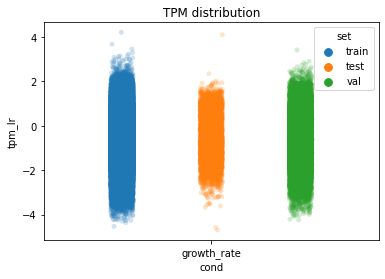

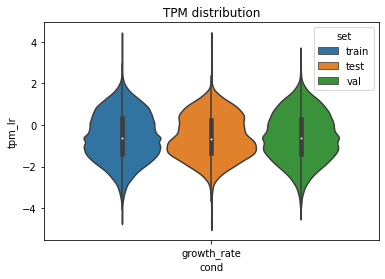

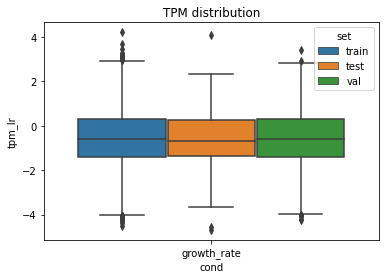

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


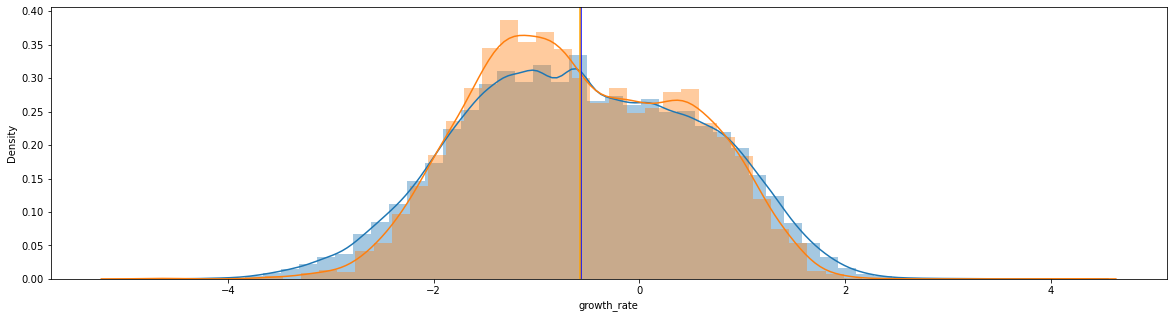


0.25:{'train': 92976, 'val': 23244, 'test': 6117}


E:173 | train loss:0.696 | val loss: 0.772:   3%|▎         | 174/5000 [09:06<4:11:57,  3.13s/it]

EarlyStopping counter: 125 out of 500


E:298 | train loss:0.684 | val loss: 0.775:   6%|▌         | 299/5000 [15:40<4:05:33,  3.13s/it]

EarlyStopping counter: 250 out of 500


E:423 | train loss:0.679 | val loss: 0.780:   8%|▊         | 424/5000 [22:12<3:59:23,  3.14s/it]

EarlyStopping counter: 375 out of 500


E:548 | train loss:0.675 | val loss: 0.786:  11%|█         | 548/5000 [28:46<3:53:43,  3.15s/it]

EarlyStopping counter: 500 out of 500
Early stopping


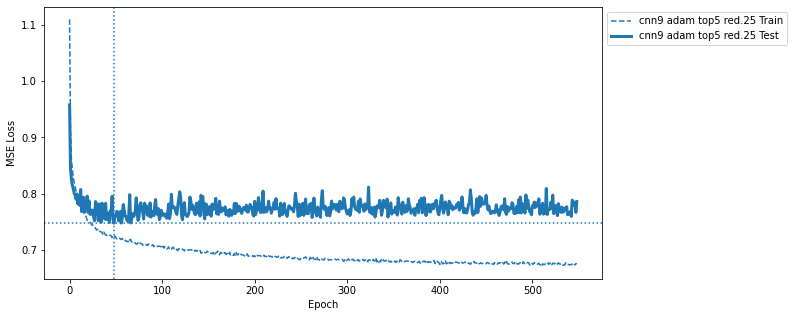

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn9 adam top5 red.25


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn9 adam top5 red.25
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn9 adam top5 red.25


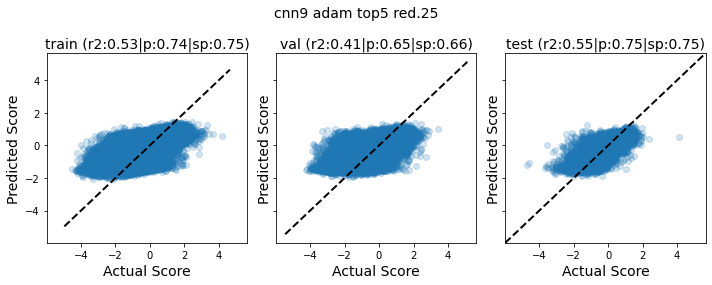

In [169]:
r = 0.25
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r)

split_sizes[r] = {}
for split in red_split_dfs:
    split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{split_sizes[r]}')

cnn9_name = 'cnn9 adam top5 red.25'
model_res[cnn9_name] = collect_model_stats(
    cnn9_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

pred_dfs[cnn9_name] = parity_pred_by_split(cnn9_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )



train reduced (9298, 12)
val reduced (2324, 12)
test reduced (612, 11)


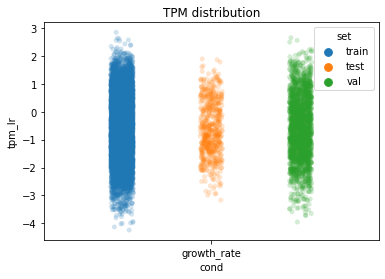

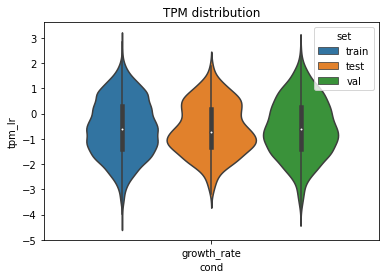

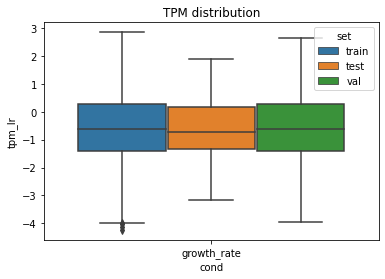

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


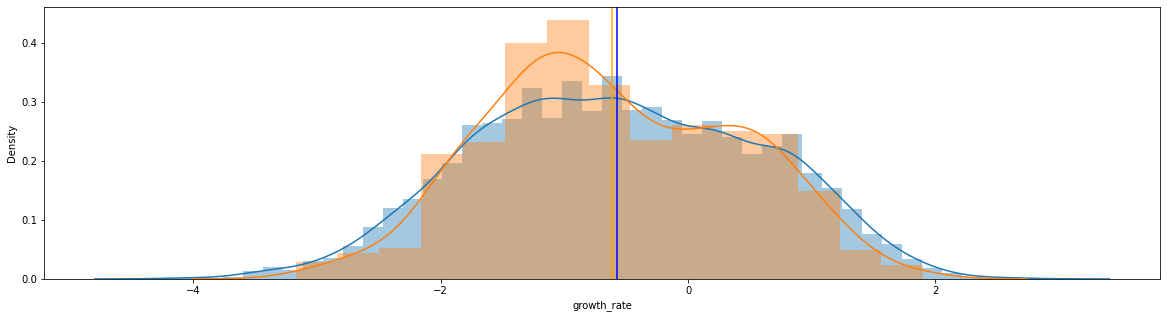


0.025:{'train': 9298, 'val': 2324, 'test': 612}


E:141 | train loss:0.404 | val loss: 1.023:   3%|▎         | 142/5000 [00:44<25:07,  3.22it/s]

EarlyStopping counter: 125 out of 500


E:266 | train loss:0.369 | val loss: 1.035:   5%|▌         | 267/5000 [01:23<24:27,  3.23it/s]

EarlyStopping counter: 250 out of 500


E:391 | train loss:0.339 | val loss: 1.047:   8%|▊         | 392/5000 [02:01<23:46,  3.23it/s]

EarlyStopping counter: 375 out of 500


E:516 | train loss:0.336 | val loss: 1.041:  10%|█         | 516/5000 [02:40<23:15,  3.21it/s]

EarlyStopping counter: 500 out of 500
Early stopping


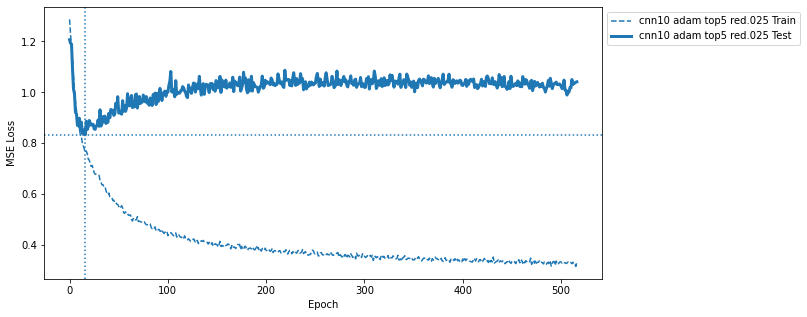

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn10 adam top5 red.025
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn10 adam top5 red.025
test split
Running cnn10 adam top5 red.025


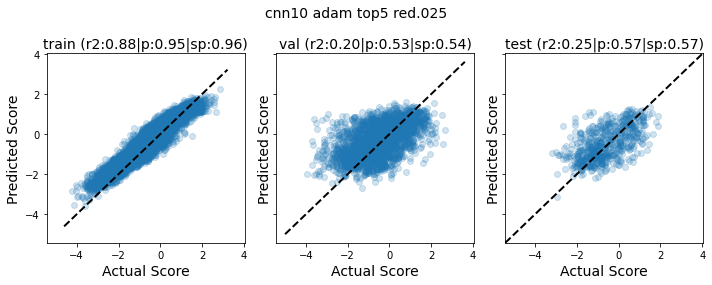

In [170]:
r = 0.025
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r)

split_sizes[r] = {}
for split in red_split_dfs:
    split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{split_sizes[r]}')


cnn10_name = 'cnn10 adam top5 red.025'
model_res[cnn10_name] = collect_model_stats(
    cnn10_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

pred_dfs[cnn10_name] = parity_pred_by_split(cnn10_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

train reduced (1860, 12)
val reduced (465, 12)
test reduced (122, 11)


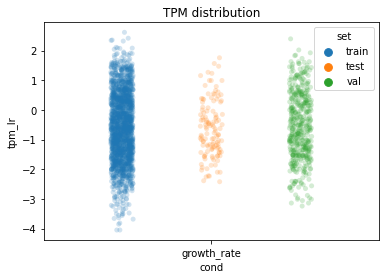

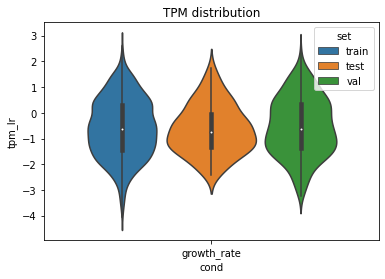

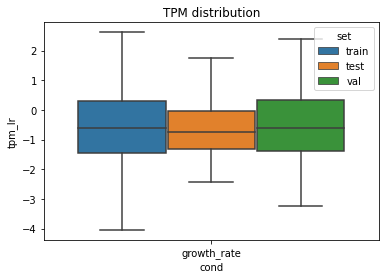

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


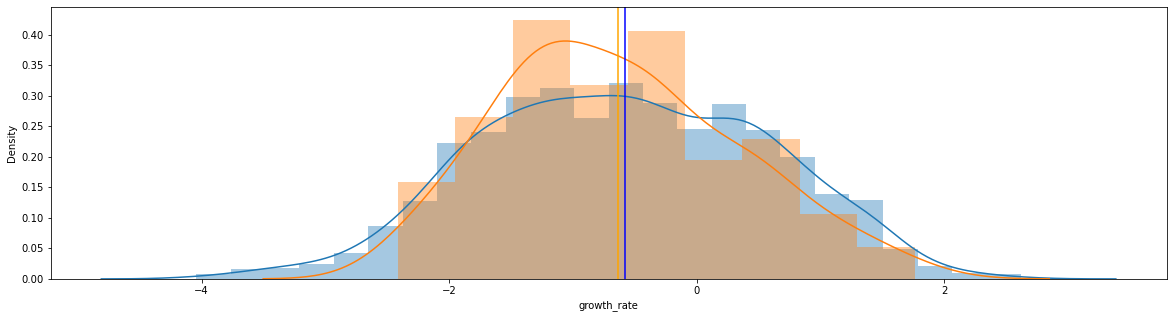


0.005:{'train': 1860, 'val': 465, 'test': 122}


E:144 | train loss:0.223 | val loss: 1.356:   3%|▎         | 144/5000 [00:09<05:10, 15.63it/s]

EarlyStopping counter: 125 out of 500


E:269 | train loss:0.164 | val loss: 1.340:   5%|▌         | 270/5000 [00:17<05:02, 15.63it/s]

EarlyStopping counter: 250 out of 500


E:394 | train loss:0.124 | val loss: 1.271:   8%|▊         | 394/5000 [00:25<04:54, 15.64it/s]

EarlyStopping counter: 375 out of 500


E:516 | train loss:0.110 | val loss: 1.258:  10%|█         | 516/5000 [00:33<04:47, 15.57it/s]


EarlyStopping counter: 500 out of 500
Early stopping


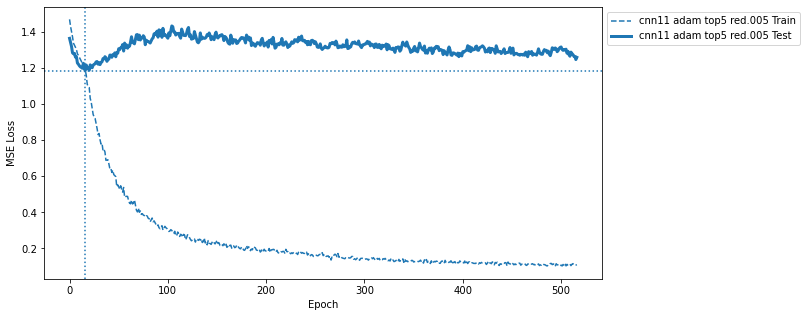

train split
Running cnn11 adam top5 red.005
val split
Running cnn11 adam top5 red.005
test split
Running cnn11 adam top5 red.005


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

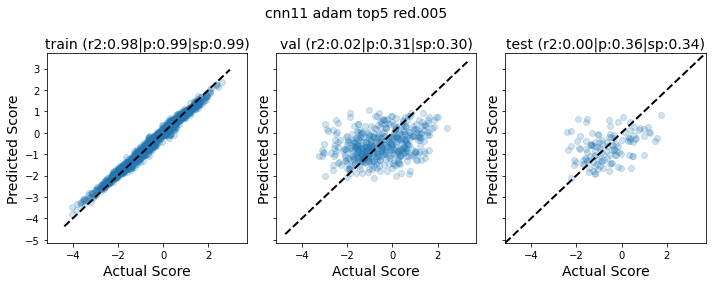

In [171]:
r = 0.005
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r)

split_sizes[r] = {}
for split in red_split_dfs:
    split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{split_sizes[r]}')


cnn11_name = 'cnn11 adam top5 red.005'
model_res[cnn11_name] = collect_model_stats(
    cnn11_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

pred_dfs[cnn11_name] = parity_pred_by_split(cnn11_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

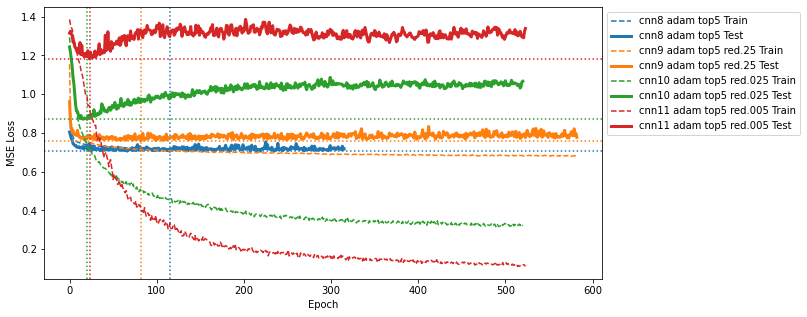

In [149]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res][1:])


1.0:{'train': 371904, 'val': 92977, 'test': 24467}
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5


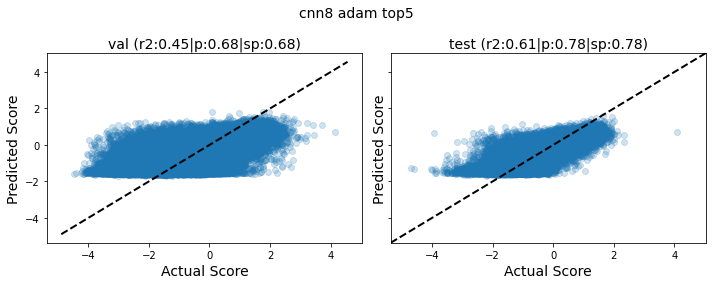

In [179]:
# put non reduced model in pred_dfs

non_red_split_dfs = {
    'train':train_df,
    'val':val_df,
    'test':test_df.reset_index(),   
}

r=1.0
split_sizes[r] = {}
for split in non_red_split_dfs:
    split_sizes[r][split] = non_red_split_dfs[split].shape[0]
print(f'\n{r}:{split_sizes[r]}')


pred_dfs[cnn8_name] = parity_pred_by_split(cnn8_name,
                                DEVICE,
                                non_red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )

In [180]:
# reduced models
ms = [cnn8_name,cnn9_name,cnn10_name,cnn11_name]
ms

['cnn8 adam top5',
 'cnn9 adam top5 red.25',
 'cnn10 adam top5 red.025',
 'cnn11 adam top5 red.005']

In [181]:
mod2red = {
    cnn8_name:1.0,
    cnn9_name:0.25,
    cnn10_name:0.025,
    cnn11_name:0.005
}

In [182]:
reduction_data = []
for mod in ms:
    # get the test set prediction score
    test_pred_df = pred_dfs[mod]['test']
    ytrue = test_pred_df['truth'].values
    ypred = test_pred_df['pred'].values
    r2 = r2_score(ytrue,ypred)
    
    # get reduction percent
    red = mod2red[mod]
    
    # get train set size
    train_size = split_sizes[red]['train']
    
    reduction_data.append([mod,red,r2,train_size])

red_res_df = pd.DataFrame(reduction_data, columns = ['model_name','reduction','r2','train_size'])
    

In [187]:
red_res_df

,model_name,reduction,r2,train_size
0,cnn8 adam top5,1.000,0.607797,371904
1,cnn9 adam top5 red.25,0.250,0.548384,92976
2,cnn10 adam top5 red.025,0.025,0.252590,9298
3,cnn11 adam top5 red.005,0.005,0.000212,1860


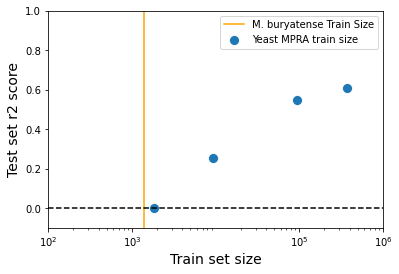

In [215]:
sns.scatterplot(data=red_res_df, x='train_size', y='r2',s=100,label="Yeast MPRA train size")
plt.xscale('log')
plt.ylim(-0.1,1)
#plt.xlim(-100,1000000)
plt.xticks([100,1000,100000,1000000])
plt.axvline(1414,c='orange',label='M. buryatense Train Size')
plt.axhline(0,c='black',linestyle='--')
plt.xlabel("Train set size",fontsize=14)
plt.ylabel("Test set r2 score",fontsize=14)
plt.legend()
plt.show()

# Shuffled versions of reduced

In [216]:
seq_col_name = 'shuffled_seq'
target_col_name = 'growth_rate'

# Dfs for the full train/test split
final_dls_shuff = tu.build_dataloaders_single(
    full_train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name
)

# Dfs from further spliting train into train and val
dls_shuff = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

shuff_ohe_train_dl,shuff_ohe_val_dl = dls_shuff['ohe']

In [225]:
full_split_dfs = {
    #'full_train':full_train_df,
    'train':train_df,
    'val':val_df,
    'test':test_df.reset_index(),   
}

In [234]:
shuff_pred_dfs = {}
shuff_split_sizes = {}


1.0:{'train': 371904, 'val': 92977, 'test': 24467}


E:53 | train loss:1.204 | val loss: 1.223:   3%|▎         | 54/2000 [11:15<6:45:19, 12.50s/it]

EarlyStopping counter: 50 out of 200


E:103 | train loss:1.192 | val loss: 1.234:   5%|▌         | 104/2000 [21:40<6:35:10, 12.51s/it]

EarlyStopping counter: 100 out of 200


E:153 | train loss:1.188 | val loss: 1.233:   8%|▊         | 154/2000 [32:05<6:24:05, 12.48s/it]

EarlyStopping counter: 150 out of 200


E:203 | train loss:1.186 | val loss: 1.241:  10%|█         | 203/2000 [42:30<6:16:17, 12.56s/it]

EarlyStopping counter: 200 out of 200
Early stopping


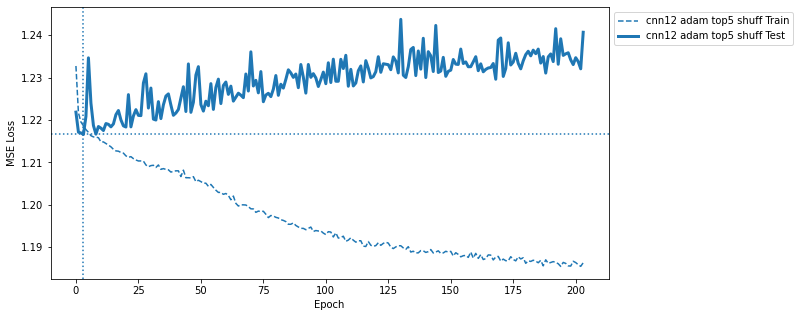

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn12 adam top5 shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn12 adam top5 shuff


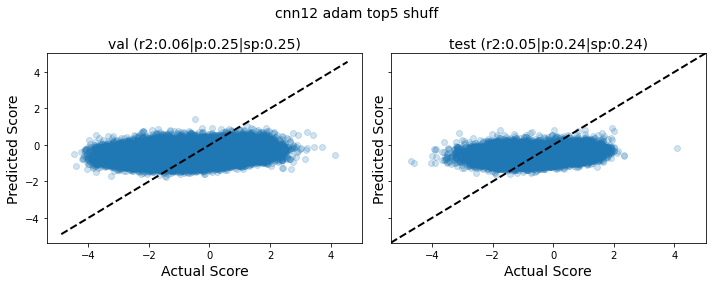

In [239]:
cnn12_name = 'cnn12 adam top5 shuff'

r=1.0
shuff_split_sizes[r] = {}
for split in full_split_dfs:
    shuff_split_sizes[r][split] = full_split_dfs[split].shape[0]
print(f'\n{r}:{shuff_split_sizes[r]}')

model_res[cnn12_name] = collect_model_stats(
    cnn12_name,
    seq_len,
    'ohe',
    shuff_ohe_train_dl,
    shuff_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

shuff_pred_dfs[cnn12_name] = parity_pred_by_split(cnn12_name,
                                DEVICE,
                                full_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )

train reduced (92976, 12)
val reduced (23244, 12)
test reduced (6117, 11)


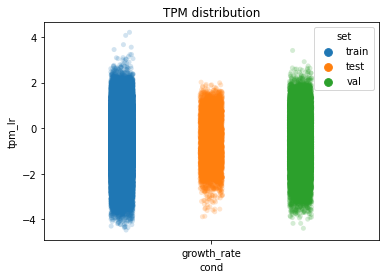

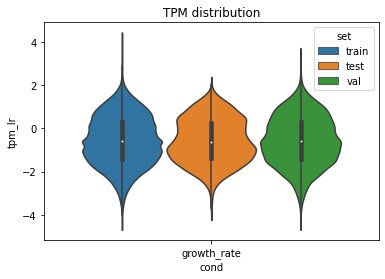

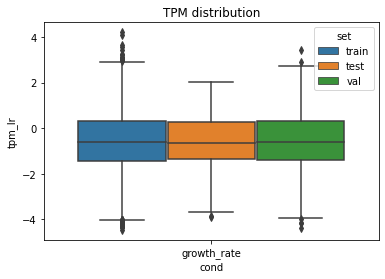

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


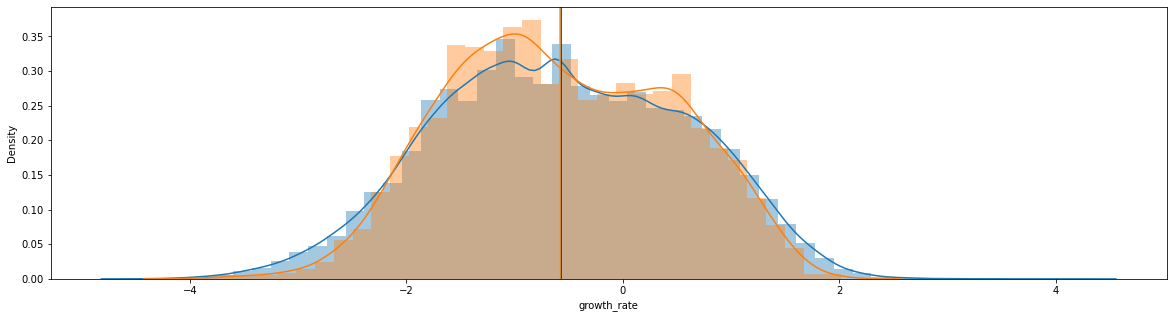


0.25:{'train': 92976, 'val': 23244, 'test': 6117}


E:57 | train loss:1.144 | val loss: 1.233:   3%|▎         | 58/2000 [03:02<1:41:54,  3.15s/it]

EarlyStopping counter: 50 out of 200


E:107 | train loss:1.120 | val loss: 1.246:   5%|▌         | 108/2000 [05:38<1:38:25,  3.12s/it]

EarlyStopping counter: 100 out of 200


E:157 | train loss:1.099 | val loss: 1.255:   8%|▊         | 158/2000 [08:14<1:35:49,  3.12s/it]

EarlyStopping counter: 150 out of 200


E:207 | train loss:1.093 | val loss: 1.258:  10%|█         | 207/2000 [10:51<1:34:02,  3.15s/it]

EarlyStopping counter: 200 out of 200
Early stopping


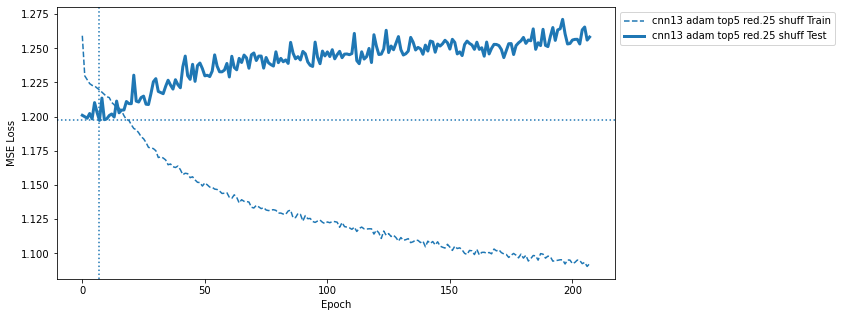

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn13 adam top5 red.25 shuff
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn13 adam top5 red.25 shuff
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn13 adam top5 red.25 shuff


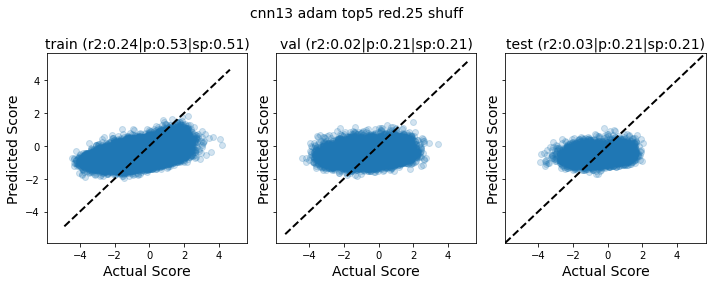

In [240]:
r = 0.25
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r,seq_col_name,target_col_name)

shuff_split_sizes[r] = {}
for split in red_split_dfs:
    shuff_split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{shuff_split_sizes[r]}')

cnn13_name = 'cnn13 adam top5 red.25 shuff'
model_res[cnn13_name] = collect_model_stats(
    cnn13_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

shuff_pred_dfs[cnn13_name] = parity_pred_by_split(cnn13_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )


train reduced (9298, 12)
val reduced (2324, 12)
test reduced (612, 11)


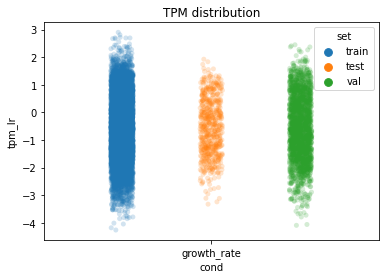

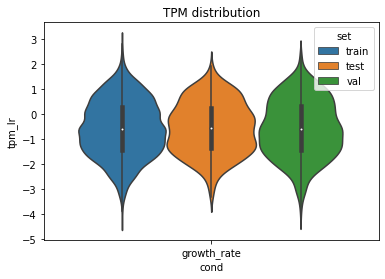

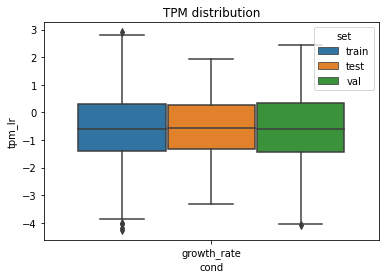

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


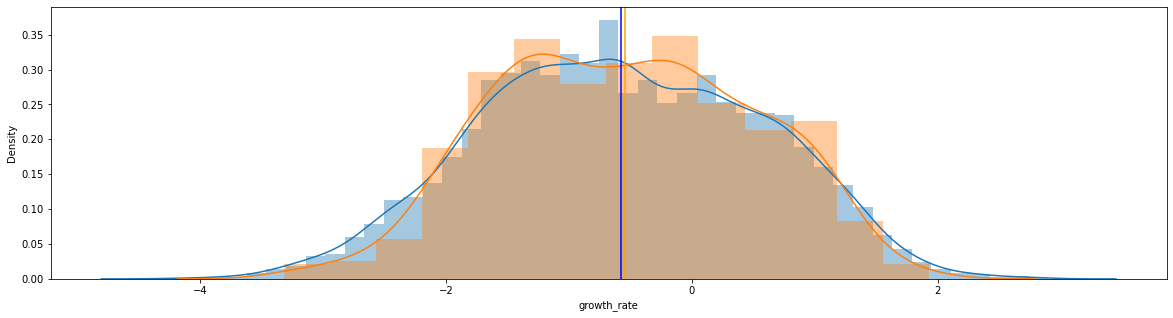


0.025:{'train': 9298, 'val': 2324, 'test': 612}


E:59 | train loss:0.880 | val loss: 1.406:   3%|▎         | 60/2000 [00:18<10:00,  3.23it/s]

EarlyStopping counter: 50 out of 200


E:109 | train loss:0.699 | val loss: 1.516:   6%|▌         | 110/2000 [00:34<09:46,  3.22it/s]

EarlyStopping counter: 100 out of 200


E:159 | train loss:0.630 | val loss: 1.565:   8%|▊         | 160/2000 [00:49<09:32,  3.22it/s]

EarlyStopping counter: 150 out of 200


E:209 | train loss:0.571 | val loss: 1.559:  10%|█         | 209/2000 [01:05<09:19,  3.20it/s]

EarlyStopping counter: 200 out of 200
Early stopping


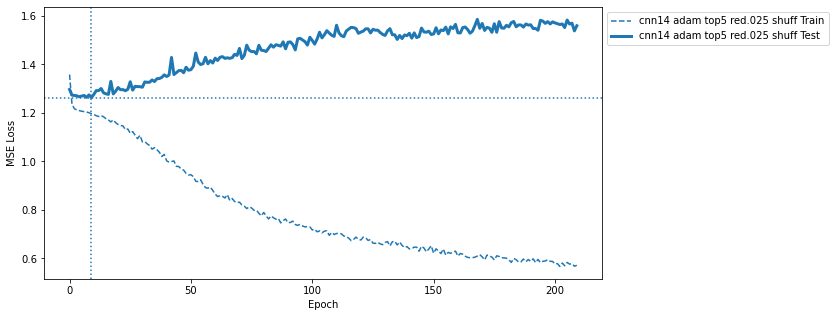

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn14 adam top5 red.025 shuff
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn14 adam top5 red.025 shuff
test split
Running cnn14 adam top5 red.025 shuff


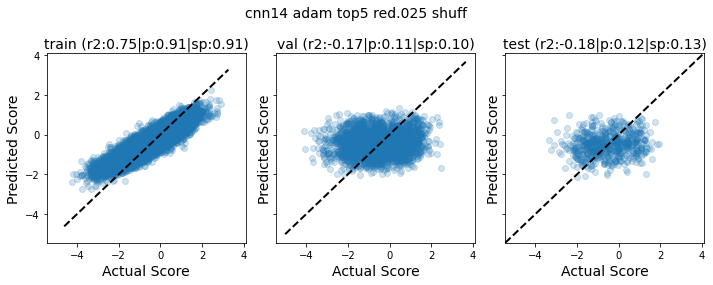

In [241]:
r = 0.025
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r,seq_col_name,target_col_name)

shuff_split_sizes[r] = {}
for split in red_split_dfs:
    shuff_split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{shuff_split_sizes[r]}')

cnn14_name = 'cnn14 adam top5 red.025 shuff'
model_res[cnn14_name] = collect_model_stats(
    cnn14_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

shuff_pred_dfs[cnn14_name] = parity_pred_by_split(cnn14_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

train reduced (1860, 12)
val reduced (465, 12)
test reduced (122, 11)


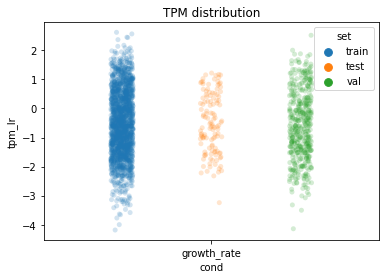

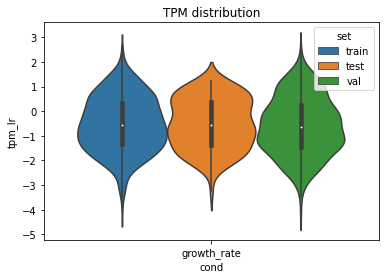

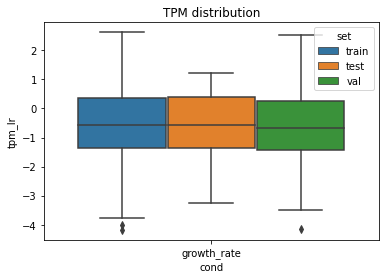

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


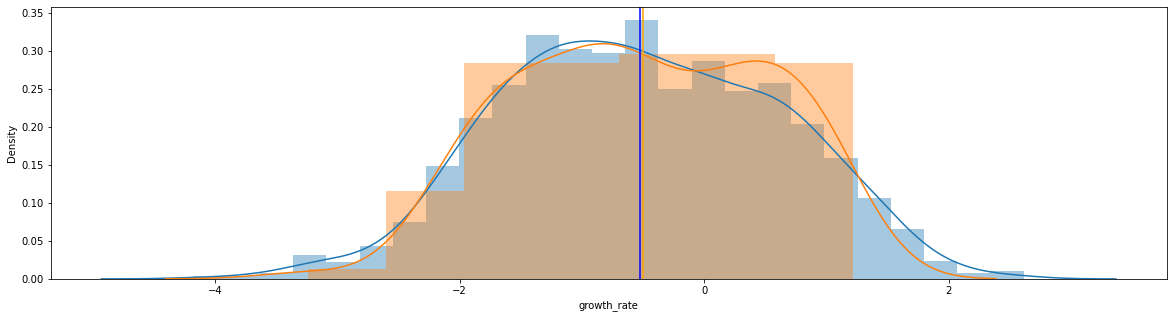


0.005:{'train': 1860, 'val': 465, 'test': 122}


E:65 | train loss:0.609 | val loss: 1.534:   3%|▎         | 66/2000 [00:04<02:03, 15.60it/s]

EarlyStopping counter: 50 out of 200


E:115 | train loss:0.378 | val loss: 1.576:   6%|▌         | 116/2000 [00:07<02:01, 15.51it/s]

EarlyStopping counter: 100 out of 200


E:165 | train loss:0.298 | val loss: 1.556:   8%|▊         | 166/2000 [00:10<01:57, 15.62it/s]

EarlyStopping counter: 150 out of 200


E:212 | train loss:0.262 | val loss: 1.556:  11%|█         | 212/2000 [00:13<01:55, 15.50it/s]


EarlyStopping counter: 200 out of 200
Early stopping


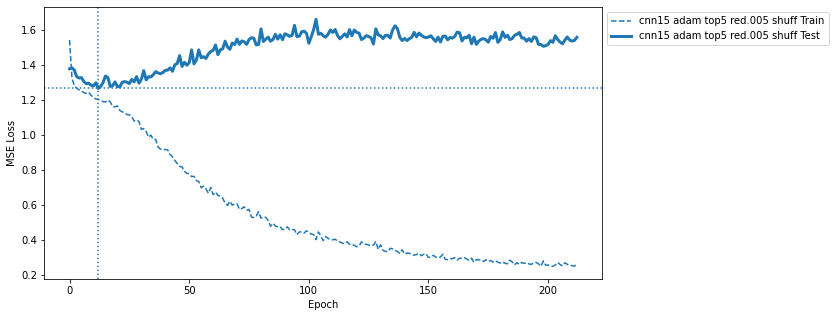

train split
Running cnn15 adam top5 red.005 shuff
val split
Running cnn15 adam top5 red.005 shuff
test split
Running cnn15 adam top5 red.005 shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

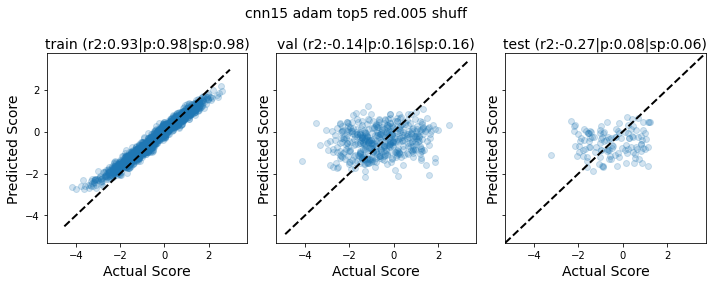

In [242]:
r = 0.005
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r,seq_col_name,target_col_name)

shuff_split_sizes[r] = {}
for split in red_split_dfs:
    shuff_split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{shuff_split_sizes[r]}')

cnn15_name = 'cnn15 adam top5 red.005 shuff'
model_res[cnn15_name] = collect_model_stats(
    cnn15_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

shuff_pred_dfs[cnn15_name] = parity_pred_by_split(cnn15_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

In [243]:
# reduced shuffled models
ms_shuff = [cnn12_name,cnn13_name,cnn14_name,cnn15_name]

mod2red_shuff = {
    cnn12_name:1.0,
    cnn13_name:0.25,
    cnn14_name:0.025,
    cnn15_name:0.005
}

shuff_reduction_data = []
for mod in ms_shuff:
    # get the test set prediction score
    test_pred_df = shuff_pred_dfs[mod]['test']
    ytrue = test_pred_df['truth'].values
    ypred = test_pred_df['pred'].values
    r2 = r2_score(ytrue,ypred)
    
    # get reduction percent
    red = mod2red_shuff[mod]
    
    # get train set size
    train_size = shuff_split_sizes[red]['train']
    
    shuff_reduction_data.append([mod,red,r2,train_size])

shuff_red_res_df = pd.DataFrame(shuff_reduction_data, columns = ['model_name','reduction','r2','train_size'])
shuff_red_res_df  

,model_name,reduction,r2,train_size
0,cnn12 adam top5 shuff,1.000,0.054940,371904
1,cnn13 adam top5 red.25 shuff,0.250,0.025253,92976
2,cnn14 adam top5 red.025 shuff,0.025,-0.178670,9298
3,cnn15 adam top5 red.005 shuff,0.005,-0.268669,1860


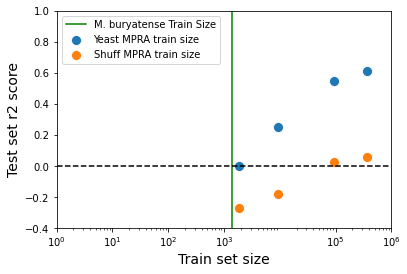

In [248]:
sns.scatterplot(data=red_res_df, x='train_size', y='r2',s=100,label="Yeast MPRA train size")
sns.scatterplot(data=shuff_red_res_df, x='train_size', y='r2',s=100,label="Shuff MPRA train size")
plt.xscale('log')
plt.ylim(-0.4,1)
#plt.xlim(-100,1000000)
plt.xticks([1,10,100,1000,100000,1000000])
plt.axvline(1414,c='green',label='M. buryatense Train Size')
plt.axhline(0,c='black',linestyle='--')
plt.xlabel("Train set size",fontsize=14)
plt.ylabel("Test set r2 score",fontsize=14)
plt.legend()
plt.show()

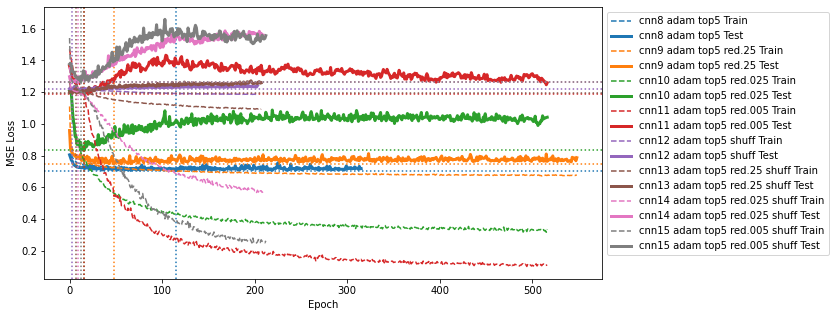

In [249]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res][1:])

# View filters

In [37]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    #print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    #print(model_weights[0].shape)
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    seq_len = model_weights.shape[-1]
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(seq_len))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

In [38]:
def view_conv_filters_for_cnn(cnn,seqs):
    conv_layers, model_weights, bias_weights = get_conv_layers_from_model(cnn)
    #view_filters(model_weights)
    filter_activations = get_filter_activations(seqs, conv_layers[0])
    view_filters_and_logos(model_weights,filter_activations)

In [41]:
cnn_wang

'cnn wang'

In [39]:
cnn_model = model_res[cnn_wang]['model']
cnn_model

DNA_2CNN_2FC_Multi(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=1152, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=1, bias=True)
  )
)

Total convolutional layers: 2
Num filters 32
filt_width 8
torch.Size([32, 4, 8])


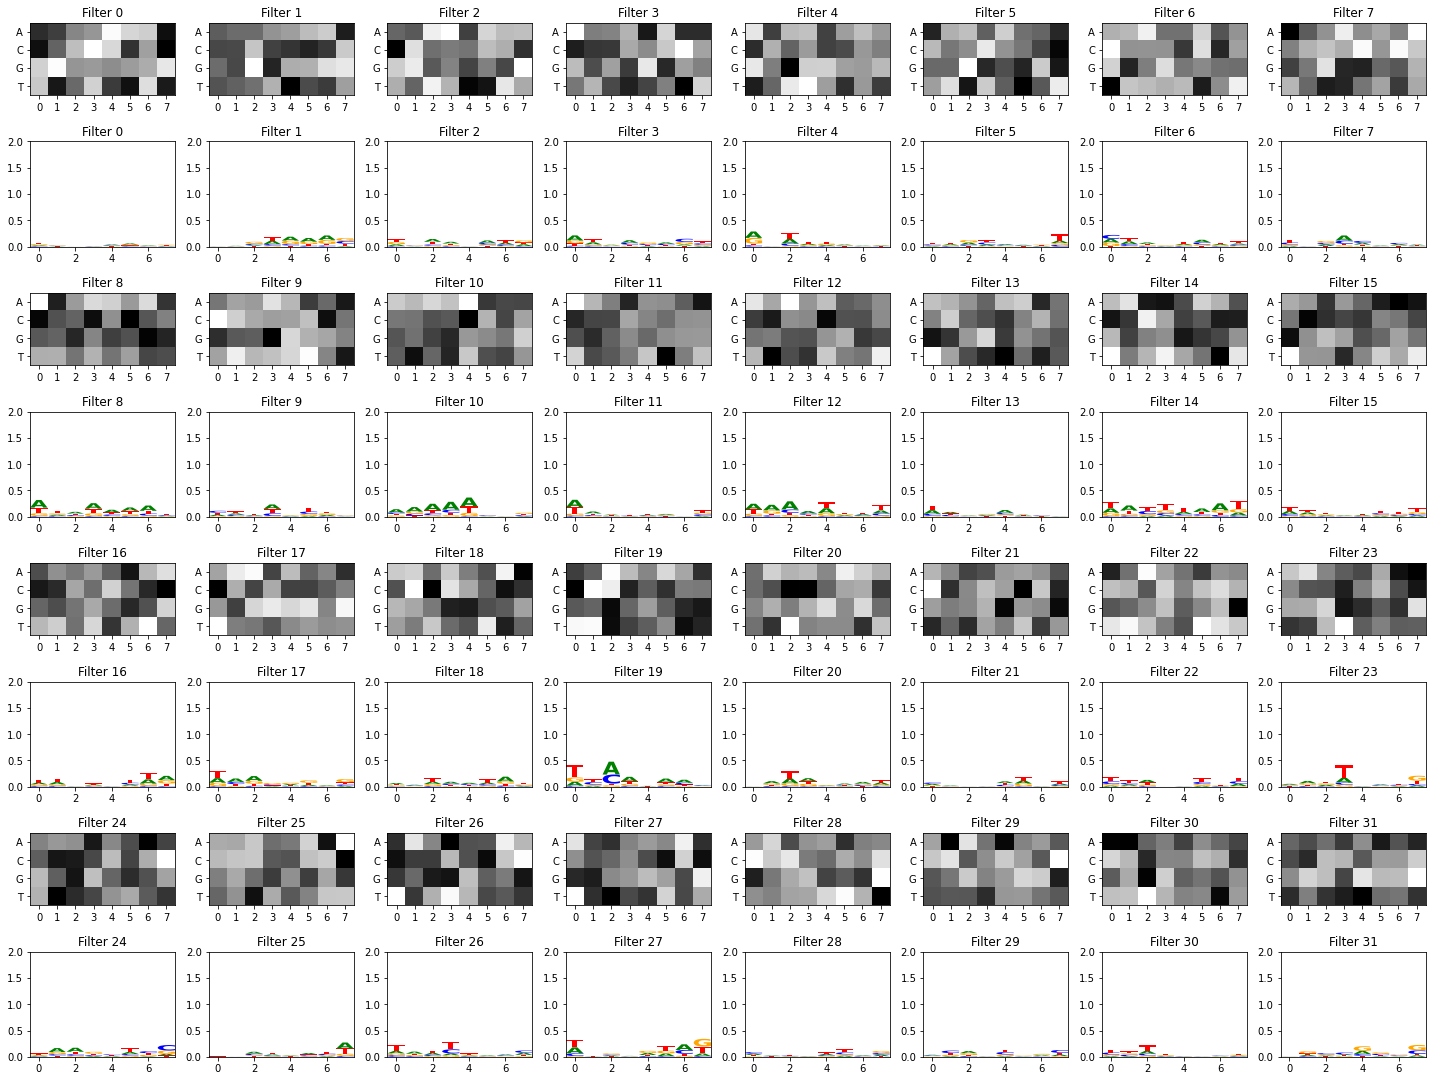

In [40]:
# all prom seq examples: just using to get activations of filters, not train or test
all_seqs = test_df['seq'].values

view_conv_filters_for_cnn(cnn_model,all_seqs)

# Save some models

In [269]:
path = 'model_out/yeast_MPRA_full_model.pth'
torch.save(cnn_model, path)

In [ ]:
# Model class must be defined somewhere
# model = torch.load(PATH)
# model.eval()

# plot data set size by r2 on test

In [154]:
model_res['cnn8 adam top5'].keys()

dict_keys(['model_name', 'model', 'train_losses', 'val_losses', 'epoch_stop', 'best_val_score', 'data_label'])

In [124]:
split_dfs['test'] = split_dfs['test'].reset_index()

In [32]:
split_dfs['test']

,index,UTR,growth_rate,t0,t1,t0_ps,t1_ps,t0_norm,t1_norm,enrich_score,shuffled_seq
0,232749,CTAGTACAGAGCAGAAAGCCCTTATACATTAGGACCTTTGCAGCAC...,0.851569,757,1631,758,1632,0.000033,0.000077,0.851569,GCTTGTAATCGCACAATAATCGCACATTACCGAGGGAAACTTGGTC...
1,65465,ACGTCAATCCCTGTCCCGTGCGTTCCTGAGCCTTATGACATCTACG...,-1.293179,590,148,591,149,0.000026,0.000007,-1.293179,CGTCCTCTATTCTCTACTTGCCTCGACCTGCCAGTCTAAGTGTCCA...
2,221380,CGTACAACTAAATGGGATCTCCTTTGAACTGTATTCCTGAACCAGC...,-0.757277,498,214,499,215,0.000022,0.000010,-0.757277,TTAATCCGCATGACCGACGAACGGTCGTAATTATCGCCACCAAGAT...
3,143417,CAACCAAGTGGTCACACAAAACGCAGAGTACAGTGCTGCCAAAACA...,0.390326,413,561,414,562,0.000018,0.000027,0.390326,CAGACCATCCGGCTGGAACAAACTGAACAACAAAGAATGACCTGGA...
4,26512,AAGCCTGTCTCGAAGAGCATACCGTATCTACGGAAGGCCAGTCCAG...,-1.329617,361,87,362,88,0.000016,0.000004,-1.329617,ACAGGAGTGGACCCAGCACTGTATTCAAGAGCCGCAGTGGTCCCGT...
...,...,...,...,...,...,...,...,...,...,...,...
24462,103065,AGTTTGCGAGACTGTACTGTCTACTTTGTAATTATCGACGAATCCT...,0.952779,101,242,102,243,0.000004,0.000011,0.952779,CACGATTACAATATCCGGTTATATTGTCCTTACCGATTATGTTAAG...
24463,97140,AGTAGAAACAAGTTTGGGAACACACGCGCCGAATGCCCCTAACTCC...,0.279999,101,123,102,124,0.000004,0.000006,0.279999,GGCGTTAGCGGCACAAGTCTTTAAAATAAACCCCCAACTGGGCCAA...
24464,372981,TAATAGCAAAGAACGTCACGGTTCTCCTATTAGTCCGCGGTTCTAT...,1.205921,101,312,102,313,0.000004,0.000015,1.205921,TATCGTGGCGTCCTAATCTTAATTACAAGTCAGAAGCAGTAGCCTA...
24465,9214,AAAGTCTTGAGGAACCAAGACCATGTAAGCTTCAAGTACAACGGAC...,-0.756093,101,43,102,44,0.000004,0.000002,-0.756093,AAATTGTAACAAAACCGCGCAAGCGAGTTCAGACACGATCTCAATG...


In [36]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 4            |        cudaMalloc retries: 5         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  339650 KB |   14264 MB |    3517 TB |    3517 TB |
|       from large pool |  339481 KB |   14264 MB |    3401 TB |    3401 TB |
|       from small pool |     169 KB |       4 MB |     116 TB |     116 TB |
|---------------------------------------------------------------------------|
| Active memory         |  339650 KB |   14264 MB |    3517 TB |    3517 TB |
|       from large pool |  339481 KB |   14264 MB |    3401 TB |

In [38]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 4            |        cudaMalloc retries: 5         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  339650 KB |   14264 MB |    3517 TB |    3517 TB |
|       from large pool |  339481 KB |   14264 MB |    3401 TB |    3401 TB |
|       from small pool |     169 KB |       4 MB |     116 TB |     116 TB |
|---------------------------------------------------------------------------|
| Active memory         |  339650 KB |   14264 MB |    3517 TB |    3517 TB |
|       from large pool |  339481 KB |   14264 MB |    3401 TB |

In [41]:
torch.cuda.empty_cache()
